In [1]:
# Import necessary libraries
import wandb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Login to wandb (if not already logged in)
wandb.login()

# Define the project and entity
project_name = "Negatives"
entity_name = "ntourne"

# Initialize the wandb API
api = wandb.Api()

# Fetch all runs from the project
runs = api.runs(f"{entity_name}/{project_name}")

wandb: Currently logged in as: ntourne to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [2]:
# Initialize a list to store results
results = []

# Iterate through runs and extract metrics
for run in runs:
    # Get the summary metrics, config, and name of the run
    summary = run.summary._json_dict
    config = run.config
    name = run.name
    
    # Combine the data into a single dictionary
    run_data = {
        "run_name": name,
        "TF": config.get("TF"),
        "celltype": config.get("celltype"),
        "neg_mode": config.get("neg_mode"),
        "cross_val_set": config.get("cross_val_set"),
        "group_name": config.get("group_name"),
        "AUROC": summary.get("test_AUROC"),
        "AUROC_HQ": summary.get("test_AUROC_HQ"),
        "val_loss": summary.get("val_loss"),
    }
    results.append(run_data)

# Convert the results into a DataFrame
results_df = pd.DataFrame(results)

wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=19 sec). Create a new API with an integer timeout larger than 19, e.g., `api = wandb.Api(timeout=29)` to increase the graphql timeout.


In [3]:
results_df = pd.DataFrame(results)

In [4]:
results_df = results_df[results_df['group_name'] == "full_run_2"] 

In [5]:
(results_df["AUROC"].isna()).sum() #! 5 NaNs!! WHY?

np.int64(1)

In [37]:
HQ_results = pd.DataFrame(results)
HQ_results = HQ_results[HQ_results['group_name'] == "full_run_2_HQ"] #! I STILL HAVE TO RUN HQ FOR full_run_2
HQ_results["neg_mode"] = "HQ training"

In [7]:
# Filter out entries where AUROC_HQ == 0 -> probably an issue with the cross val split 
filtered_out_count = results_df[(results_df['AUROC_HQ'] == 0) | (results_df['AUROC_HQ'].isna())].shape[0]

# Filter the DataFrame to exclude these entries
results_df = results_df[~((results_df['AUROC_HQ'] == 0) | (results_df['AUROC_HQ'].isna()))]

# Print the count of filtered-out entries
print(f"Number of entries where AUROC_HQ == 0: {filtered_out_count}")

Number of entries where AUROC_HQ == 0: 1


In [8]:
results_df[(results_df['AUROC_HQ'] == 1)]

,run_name,TF,celltype,neg_mode,cross_val_set,group_name,AUROC,AUROC_HQ,val_loss


In [9]:
results_df["TF"].value_counts() # this doesn't work now because there are multiple celltypes

TF
CTCF                   144
YY1_(SC-281)            96
Max                     96
ELF1_(SC-631)           96
USF-1                   96
ATF3                    96
ZBTB33                  96
SRF                     72
TCF7L2                  72
RFX5_(200-401-194)      72
SP1                     72
USF2                    72
SIX5                    72
MAZ_(ab85725)           72
ETS1                    72
Mxi1_(AF4185)           72
TBP                     72
CEBPB_(SC-150)          72
Nrf1                    72
ZNF274                  72
JunD                    72
TCF12                   71
Znf143_(16618-1-AP)     48
Egr-1                   48
ELK1_(1277-1)           48
BHLHE40                 48
TEAD4_(SC-101184)       48
NFIC_(SC-81335)         48
NF-YA                   48
FOXA1_(SC-101058)       48
MEF2A                   48
NF-YB                   48
STAT5A_(SC-74442)       48
MafK_(ab50322)          48
RXRA                    48
FOSL2                   48
MafF_(M8194)            4

In [10]:
results_df["celltype_TF"] = results_df["celltype"]+"_"+results_df["TF"]# this doesn't work now because there are multiple celltypes

In [11]:
output = results_df["celltype_TF"].value_counts() # this doesn't work now because there are multiple celltypes

In [12]:
output.to_dict()

{'MCF-7_CTCF': 24,
 'MCF-7_TCF7L2': 24,
 'MCF-7_ZNF217': 24,
 'MCF-7_GATA3_(SC-268)': 24,
 'GM12878_CTCF': 24,
 'GM12878_YY1_(SC-281)': 24,
 'GM12878_TBP': 24,
 'GM12878_Egr-1': 24,
 'GM12878_Mxi1_(AF4185)': 24,
 'GM12878_SRF': 24,
 'GM12878_MAZ_(ab85725)': 24,
 'GM12878_ELK1_(1277-1)': 24,
 'GM12878_SIX5': 24,
 'GM12878_USF-1': 24,
 'GM12878_SP1': 24,
 'GM12878_RFX5_(200-401-194)': 24,
 'GM12878_ELF1_(SC-631)': 24,
 'GM12878_ATF2_(SC-81188)': 24,
 'GM12878_NF-YB': 24,
 'GM12878_USF2': 24,
 'GM12878_Znf143_(16618-1-AP)': 24,
 'GM12878_ZEB1_(SC-25388)': 24,
 'GM12878_Pbx3': 24,
 'GM12878_MEF2A': 24,
 'GM12878_TCF12': 24,
 'GM12878_Max': 24,
 'GM12878_STAT5A_(SC-74442)': 24,
 'GM12878_NFIC_(SC-81335)': 24,
 'GM12878_Nrf1': 24,
 'GM12878_CEBPB_(SC-150)': 24,
 'GM12878_FOXM1_(SC-502)': 24,
 'GM12878_RXRA': 24,
 'GM12878_ZBTB33': 24,
 'GM12878_ETS1': 24,
 'GM12878_ATF3': 24,
 'GM12878_NF-YA': 24,
 'GM12878_IKZF1_(IkN)_(UCLA)': 24,
 'GM12878_JunD': 24,
 'GM12878_ZZZ3': 24,
 'GM12878_ZNF274':

THIS WAS FOR RUN_1 NOT THIS ONE. BUT THIS MIGHT BE BECAUSE WE ARE NOW LOOKING AT TEST DATA
THese have issues!:
 'GM12878_RXRA': 16,
 'GM12878_ZBTB33': 16,
 'GM12878_ATF3': 16,
 'HepG2_Nrf1': 16,
 'HepG2_ZBTB33': 16,
 'HepG2_TCF12': 16,
 'GM12878_JunD': 8

In [13]:
# Filter out TFs with less than 24 samples
results_df = results_df.groupby('TF').filter(lambda x: len(x) >= 24)

In [14]:
results_df["celltype"].value_counts() 

celltype
GM12878    864
K562       864
HepG2      815
A549       336
MCF-7       96
HEK293      48
Name: count, dtype: int64

In [15]:
results_df["TF-neg_mode"] = results_df["TF"]+"_"+results_df["neg_mode"]
results_df["TF-neg_mode-celltype"] = results_df["TF"]+"_"+results_df["neg_mode"]+"_"+results_df["celltype"]

Now looking at the difference between HQ and normal AUROC. Best done per cell type because there is too much data!


In [16]:
tf_per_celltype = results_df.groupby("celltype")["TF"].nunique()
print(tf_per_celltype)

celltype
A549       14
GM12878    36
HEK293      2
HepG2      34
K562       36
MCF-7       4
Name: TF, dtype: int64


### K562

/tmp/ipykernel_854334/3805880585.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  celltype_df['TF'] = pd.Categorical(celltype_df['TF'], categories=tf_order, ordered=True)
/tmp/ipykernel_854334/3805880585.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  celltype_df['neg_mode'] = pd.Categorical(celltype_df['neg_mode'], categories=neg_sampling_order, ordered=True)


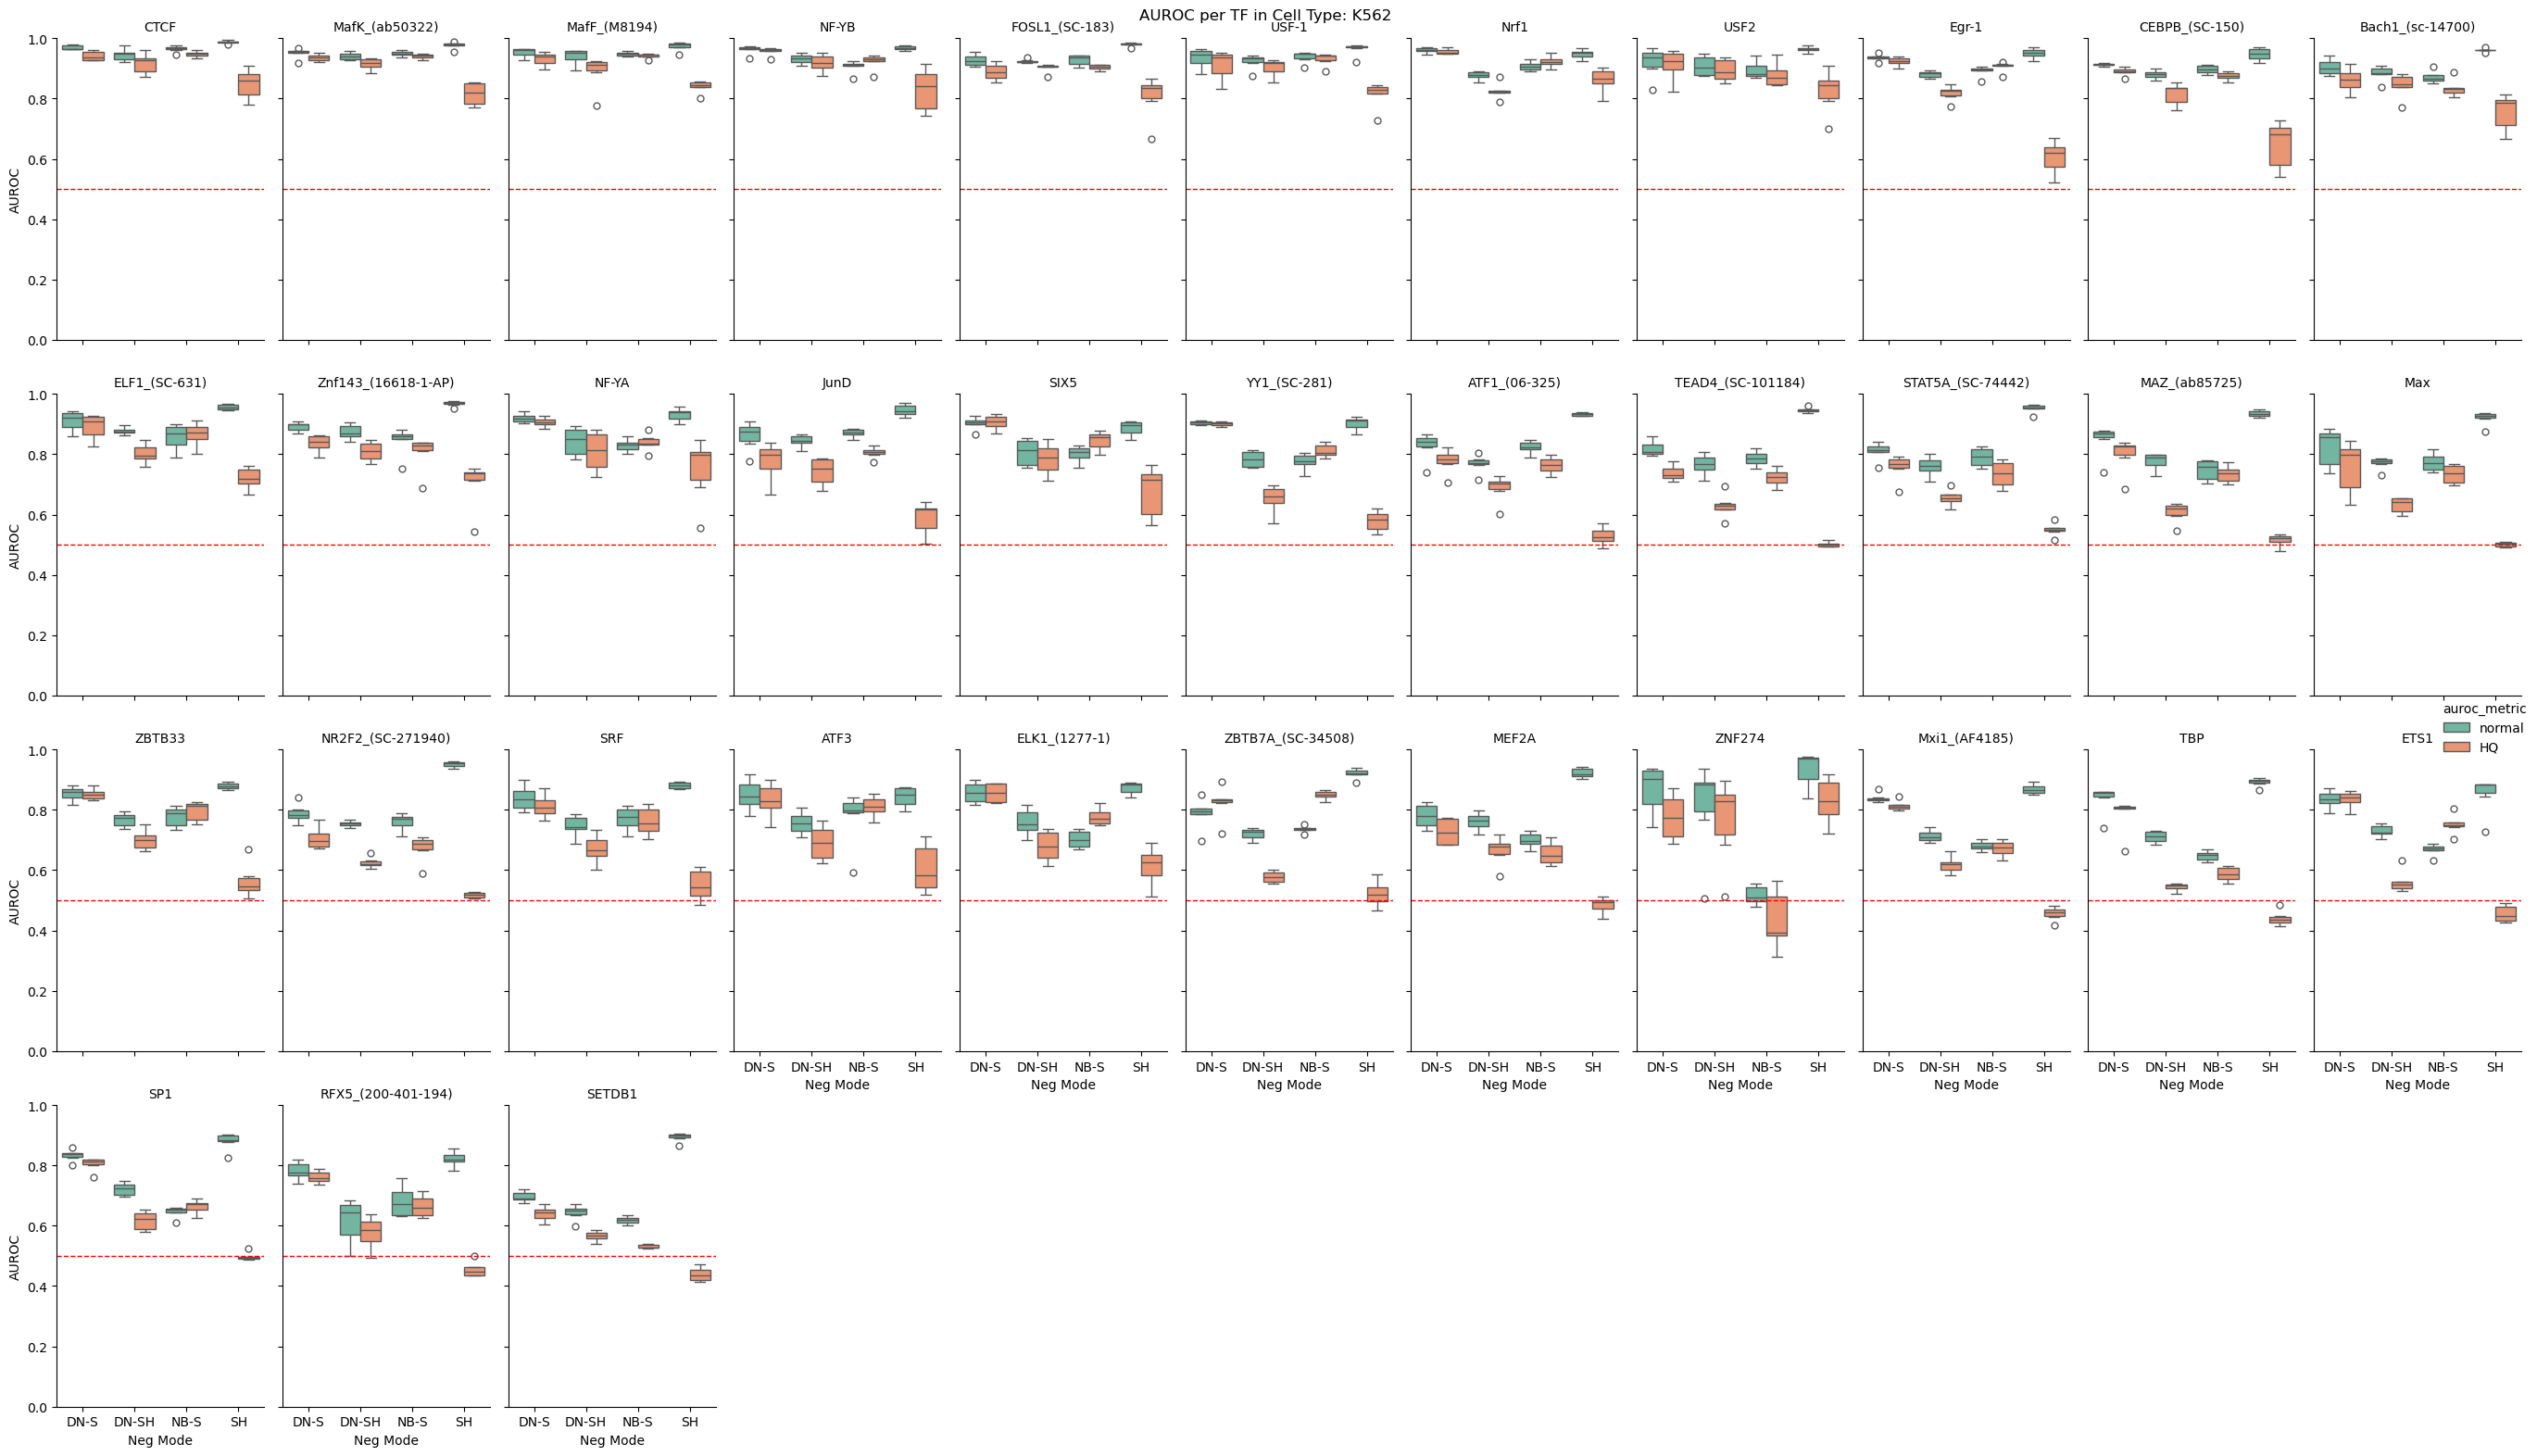

In [17]:
celltype = "K562"
# Filter the DataFrame for the current cell type
celltype_df = results_df[results_df['celltype'] == celltype]
mean_auroc_per_tf = celltype_df.groupby('TF')['AUROC'].mean().sort_values(ascending=False)
tf_order = mean_auroc_per_tf.index.tolist()

# Create a custom order for neg_sampling types
neg_sampling_order = ['dinucl_sampled', 'dinucl_shuffled', 'neighbors', 'shuffled']

# Sort the DataFrame by TF (using the custom order) and neg_sampling type
celltype_df['TF'] = pd.Categorical(celltype_df['TF'], categories=tf_order, ordered=True)
celltype_df['neg_mode'] = pd.Categorical(celltype_df['neg_mode'], categories=neg_sampling_order, ordered=True)
celltype_df = celltype_df.sort_values(['TF', 'neg_mode'])

# Create a new DataFrame with AUROC and AUROC_HQ combined into a single column
melted_df = pd.melt(
    celltype_df.sort_values(by=['TF', 'neg_mode']),
    id_vars=['TF', 'neg_mode'],
    value_vars=['AUROC', 'AUROC_HQ'],
    var_name='auroc_metric',
    value_name='AUROC_value'
)

# Map the metric names to more descriptive labels
melted_df['auroc_metric'] = melted_df['auroc_metric'].map({'AUROC': 'normal', 'AUROC_HQ': 'HQ'})

# Shorten neg_mode labels
neg_mode_labels = {
    'dinucl_sampled': 'DN-S',
    'dinucl_shuffled': 'DN-SH',
    'neighbors': 'NB-S',
    'shuffled': 'SH'
}

# Apply and order short labels
melted_df['neg_mode_short'] = melted_df['neg_mode'].map(neg_mode_labels)
neg_mode_order = ['DN-S', 'DN-SH', 'NB-S', 'SH']
melted_df['neg_mode_short'] = pd.Categorical(melted_df['neg_mode_short'], categories=neg_mode_order, ordered=True)

# Create the catplot
g = sns.catplot(
    data=melted_df,
    x='neg_mode_short',
    col='TF',
    y='AUROC_value',
    hue='auroc_metric',
    kind='box',
    col_wrap=11,
    height=4,
    aspect=0.6,
    palette='Set2'
)
g.set(ylim=(0, 1))
for ax in g.axes.flatten():
    ax.axhline(0.5, linestyle='--', color='red', linewidth=1)
# Titles and labels
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Neg Mode", "AUROC")

# Fix x-tick rotation manually
# for ax in g.axes.flatten():
#     for label in ax.get_xticklabels():
#         label.set_rotation(90)
#     ax.axhline(0.5, linestyle='--', color='red', linewidth=1)
g.fig.suptitle(f"AUROC per TF in Cell Type: {celltype}")
plt.tight_layout()
plt.show()


/tmp/ipykernel_854334/351812084.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  celltype_df['TF'] = pd.Categorical(celltype_df['TF'], categories=tf_order, ordered=True)
/tmp/ipykernel_854334/351812084.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  celltype_df['neg_mode'] = pd.Categorical(celltype_df['neg_mode'], categories=neg_sampling_order, ordered=True)


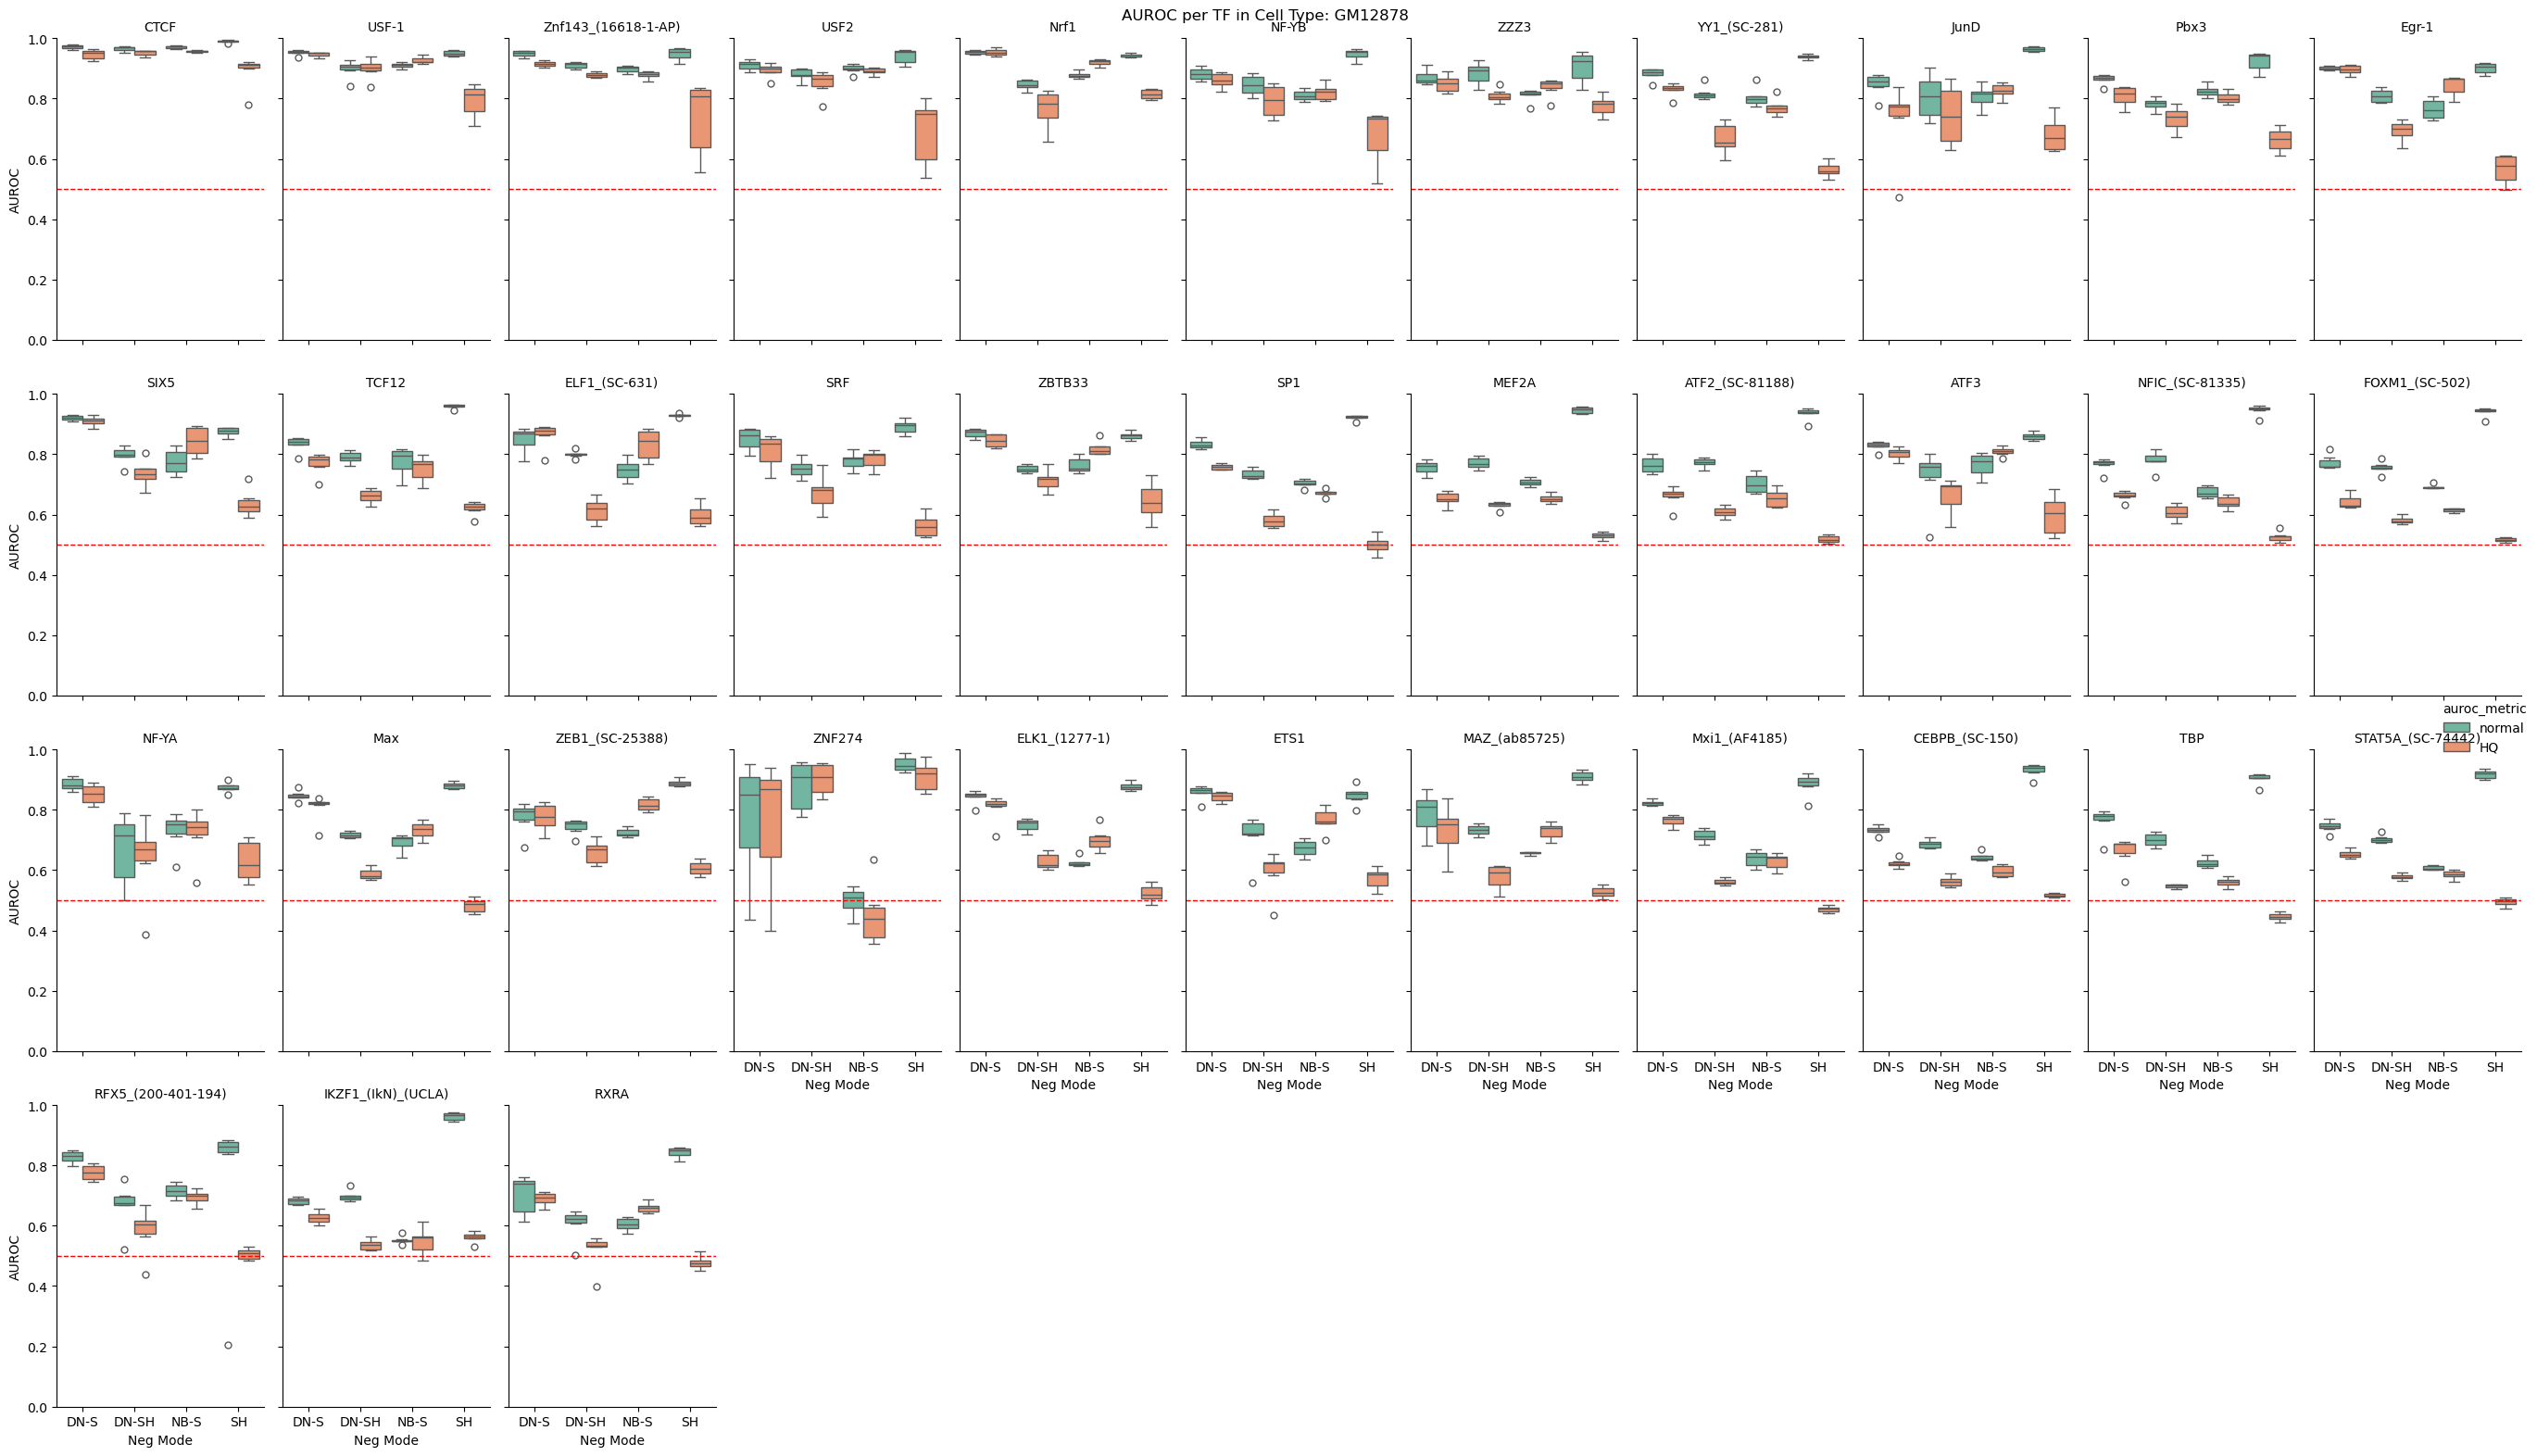

In [18]:
celltype = "GM12878"
# Filter the DataFrame for the current cell type
celltype_df = results_df[results_df['celltype'] == celltype]
mean_auroc_per_tf = celltype_df.groupby('TF')['AUROC'].mean().sort_values(ascending=False)
tf_order = mean_auroc_per_tf.index.tolist()

# Create a custom order for neg_sampling types
neg_sampling_order = ['dinucl_sampled', 'dinucl_shuffled', 'neighbors', 'shuffled']

# Sort the DataFrame by TF (using the custom order) and neg_sampling type
celltype_df['TF'] = pd.Categorical(celltype_df['TF'], categories=tf_order, ordered=True)
celltype_df['neg_mode'] = pd.Categorical(celltype_df['neg_mode'], categories=neg_sampling_order, ordered=True)
celltype_df = celltype_df.sort_values(['TF', 'neg_mode'])

# Create a new DataFrame with AUROC and AUROC_HQ combined into a single column
melted_df = pd.melt(
    celltype_df.sort_values(by=['TF', 'neg_mode']),
    id_vars=['TF', 'neg_mode'],
    value_vars=['AUROC', 'AUROC_HQ'],
    var_name='auroc_metric',
    value_name='AUROC_value'
)

# Map the metric names to more descriptive labels
melted_df['auroc_metric'] = melted_df['auroc_metric'].map({'AUROC': 'normal', 'AUROC_HQ': 'HQ'})

# Shorten neg_mode labels
neg_mode_labels = {
    'dinucl_sampled': 'DN-S',
    'dinucl_shuffled': 'DN-SH',
    'neighbors': 'NB-S',
    'shuffled': 'SH'
}

# Apply and order short labels
melted_df['neg_mode_short'] = melted_df['neg_mode'].map(neg_mode_labels)
neg_mode_order = ['DN-S', 'DN-SH', 'NB-S', 'SH']
melted_df['neg_mode_short'] = pd.Categorical(melted_df['neg_mode_short'], categories=neg_mode_order, ordered=True)

# Create the catplot
g = sns.catplot(
    data=melted_df,
    x='neg_mode_short',
    col='TF',
    y='AUROC_value',
    hue='auroc_metric',
    kind='box',
    col_wrap=11,
    height=4,
    aspect=0.6,
    palette='Set2'
)
g.set(ylim=(0, 1))
for ax in g.axes.flatten():
    ax.axhline(0.5, linestyle='--', color='red', linewidth=1)
# Titles and labels
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Neg Mode", "AUROC")

# Fix x-tick rotation manually
# for ax in g.axes.flatten():
#     for label in ax.get_xticklabels():
#         label.set_rotation(90)
#     ax.axhline(0.5, linestyle='--', color='red', linewidth=1)
g.fig.suptitle(f"AUROC per TF in Cell Type: {celltype}")
plt.tight_layout()
plt.show()

/tmp/ipykernel_854334/3165904761.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  celltype_df['TF'] = pd.Categorical(celltype_df['TF'], categories=tf_order, ordered=True)
/tmp/ipykernel_854334/3165904761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  celltype_df['neg_mode'] = pd.Categorical(celltype_df['neg_mode'], categories=neg_sampling_order, ordered=True)


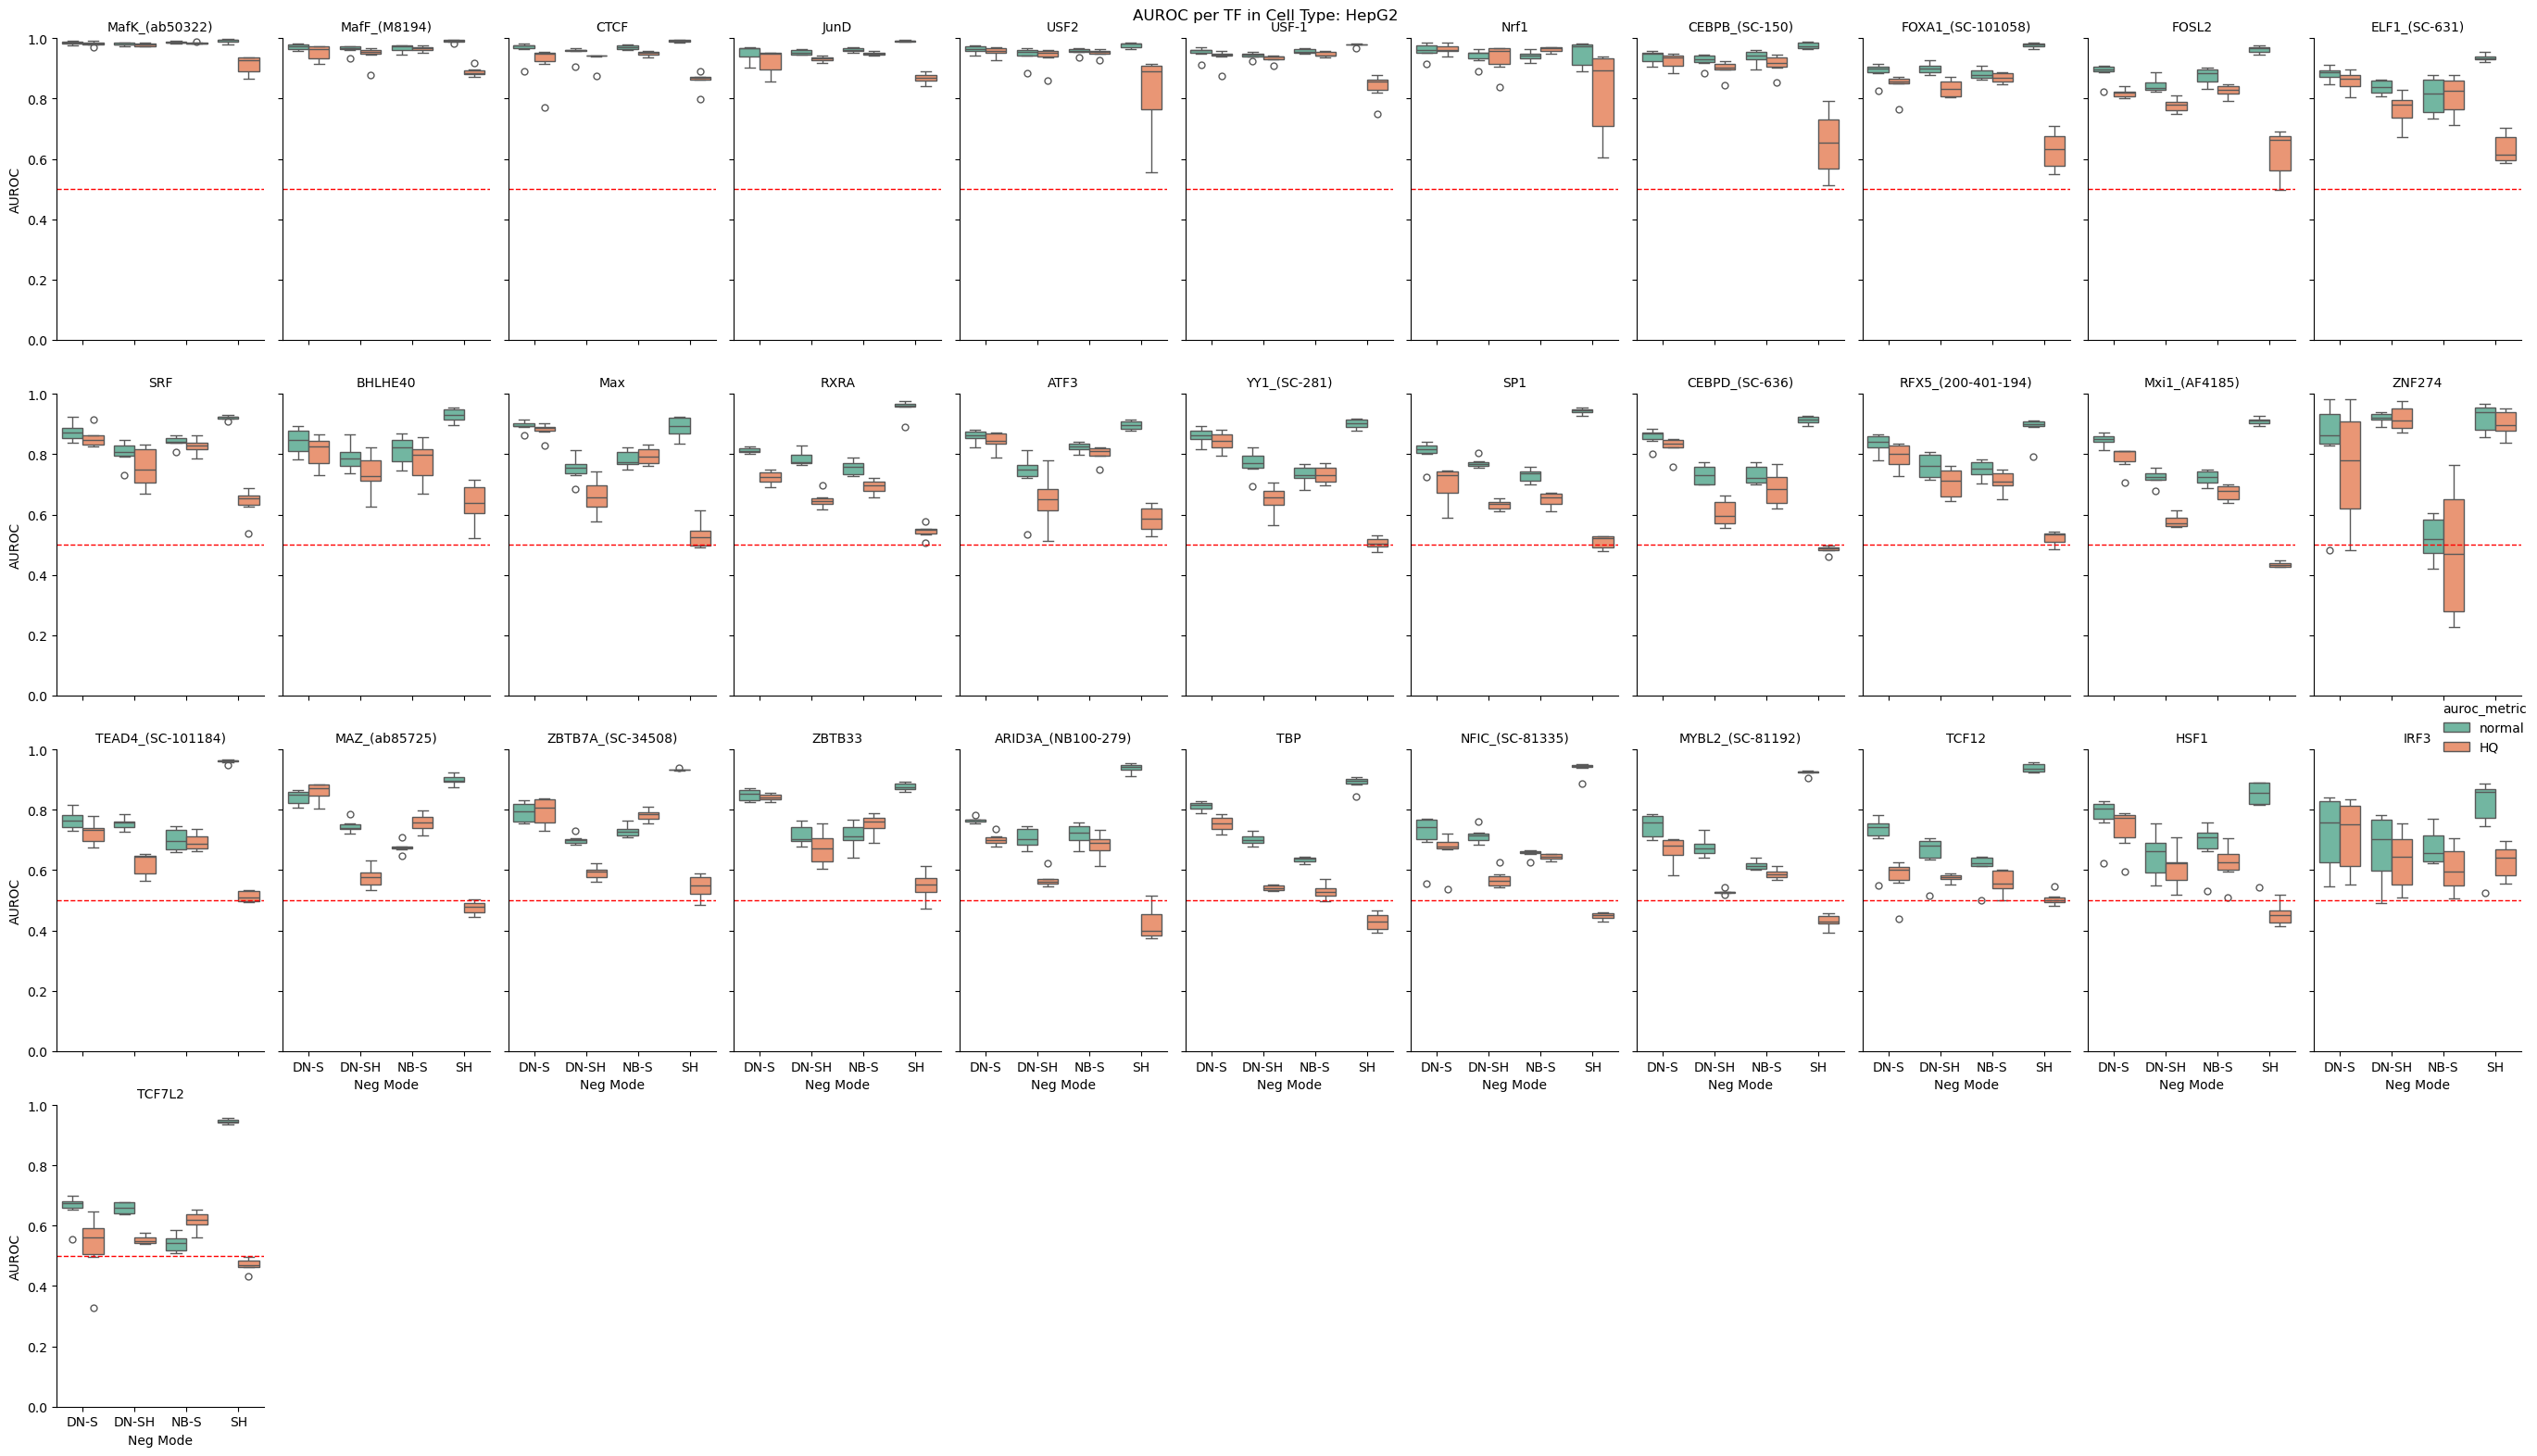

In [19]:
celltype = "HepG2"
# Filter the DataFrame for the current cell type
celltype_df = results_df[results_df['celltype'] == celltype]
mean_auroc_per_tf = celltype_df.groupby('TF')['AUROC'].mean().sort_values(ascending=False)
tf_order = mean_auroc_per_tf.index.tolist()

# Create a custom order for neg_sampling types
neg_sampling_order = ['dinucl_sampled', 'dinucl_shuffled', 'neighbors', 'shuffled']

# Sort the DataFrame by TF (using the custom order) and neg_sampling type
celltype_df['TF'] = pd.Categorical(celltype_df['TF'], categories=tf_order, ordered=True)
celltype_df['neg_mode'] = pd.Categorical(celltype_df['neg_mode'], categories=neg_sampling_order, ordered=True)
celltype_df = celltype_df.sort_values(['TF', 'neg_mode'])

# Create a new DataFrame with AUROC and AUROC_HQ combined into a single column
melted_df = pd.melt(
    celltype_df.sort_values(by=['TF', 'neg_mode']),
    id_vars=['TF', 'neg_mode'],
    value_vars=['AUROC', 'AUROC_HQ'],
    var_name='auroc_metric',
    value_name='AUROC_value'
)

# Map the metric names to more descriptive labels
melted_df['auroc_metric'] = melted_df['auroc_metric'].map({'AUROC': 'normal', 'AUROC_HQ': 'HQ'})

# Shorten neg_mode labels
neg_mode_labels = {
    'dinucl_sampled': 'DN-S',
    'dinucl_shuffled': 'DN-SH',
    'neighbors': 'NB-S',
    'shuffled': 'SH'
}

# Apply and order short labels
melted_df['neg_mode_short'] = melted_df['neg_mode'].map(neg_mode_labels)
neg_mode_order = ['DN-S', 'DN-SH', 'NB-S', 'SH']
melted_df['neg_mode_short'] = pd.Categorical(melted_df['neg_mode_short'], categories=neg_mode_order, ordered=True)

# Create the catplot
g = sns.catplot(
    data=melted_df,
    x='neg_mode_short',
    col='TF',
    y='AUROC_value',
    hue='auroc_metric',
    kind='box',
    col_wrap=11,
    height=4,
    aspect=0.6,
    palette='Set2'
)
g.set(ylim=(0, 1))
for ax in g.axes.flatten():
    ax.axhline(0.5, linestyle='--', color='red', linewidth=1)
# Titles and labels
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Neg Mode", "AUROC")

# Fix x-tick rotation manually
# for ax in g.axes.flatten():
#     for label in ax.get_xticklabels():
#         label.set_rotation(90)
#     ax.axhline(0.5, linestyle='--', color='red', linewidth=1)
g.fig.suptitle(f"AUROC per TF in Cell Type: {celltype}")
plt.tight_layout()
plt.show()

/tmp/ipykernel_854334/1354341614.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  celltype_df['TF'] = pd.Categorical(celltype_df['TF'], categories=tf_order, ordered=True)
/tmp/ipykernel_854334/1354341614.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  celltype_df['neg_mode'] = pd.Categorical(celltype_df['neg_mode'], categories=neg_sampling_order, ordered=True)


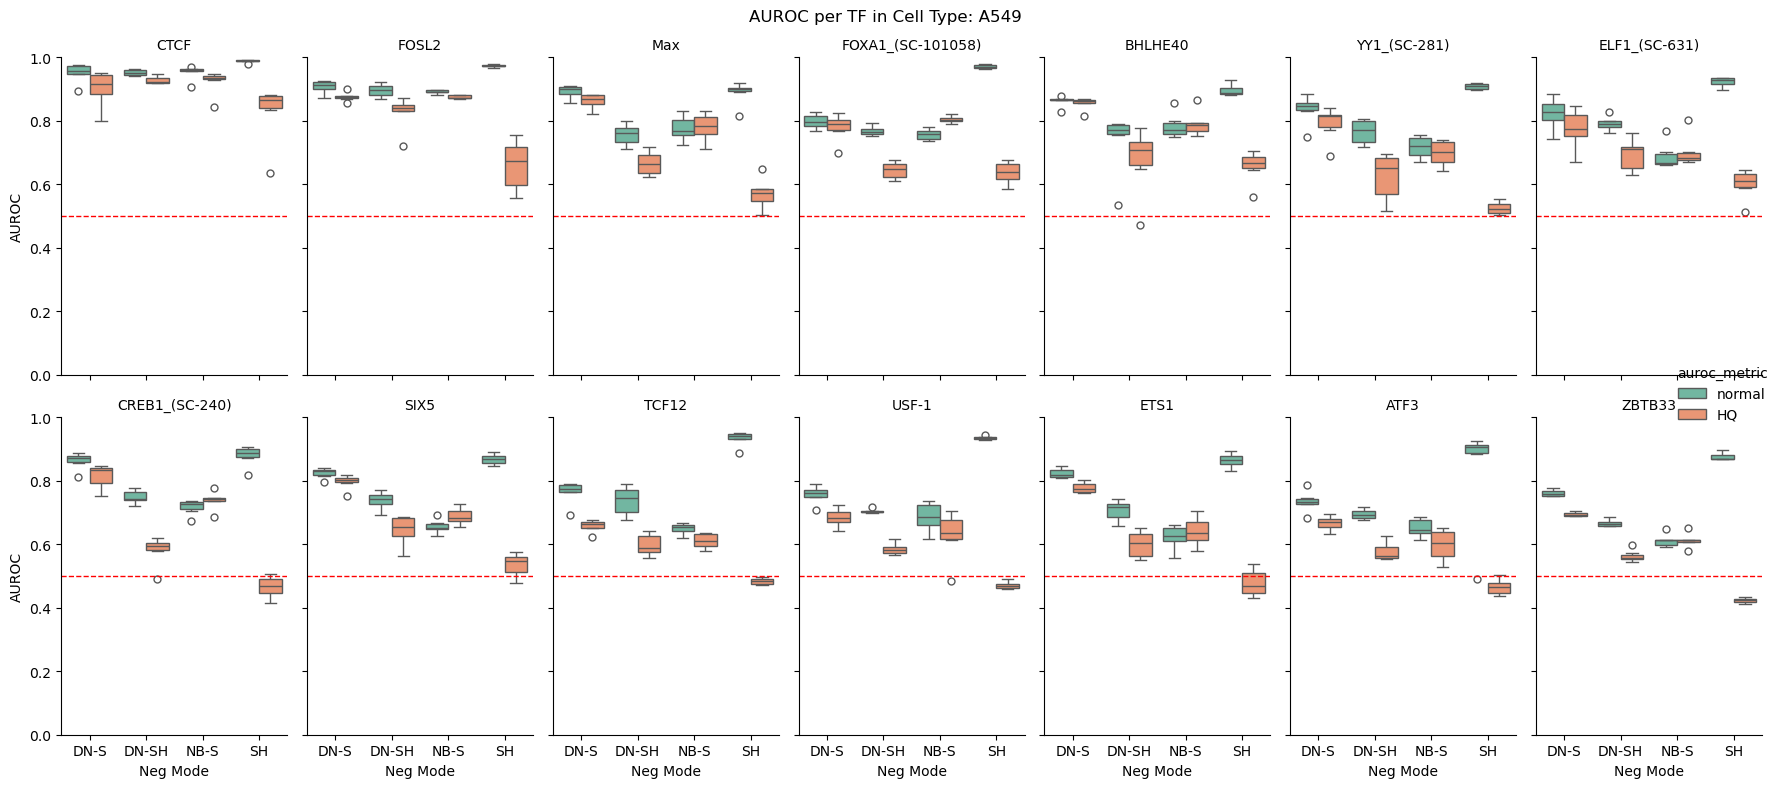

In [20]:
celltype = "A549"
# Filter the DataFrame for the current cell type
celltype_df = results_df[results_df['celltype'] == celltype]
mean_auroc_per_tf = celltype_df.groupby('TF')['AUROC'].mean().sort_values(ascending=False)
tf_order = mean_auroc_per_tf.index.tolist()

# Create a custom order for neg_sampling types
neg_sampling_order = ['dinucl_sampled', 'dinucl_shuffled', 'neighbors', 'shuffled']

# Sort the DataFrame by TF (using the custom order) and neg_sampling type
celltype_df['TF'] = pd.Categorical(celltype_df['TF'], categories=tf_order, ordered=True)
celltype_df['neg_mode'] = pd.Categorical(celltype_df['neg_mode'], categories=neg_sampling_order, ordered=True)
celltype_df = celltype_df.sort_values(['TF', 'neg_mode'])

# Create a new DataFrame with AUROC and AUROC_HQ combined into a single column
melted_df = pd.melt(
    celltype_df.sort_values(by=['TF', 'neg_mode']),
    id_vars=['TF', 'neg_mode'],
    value_vars=['AUROC', 'AUROC_HQ'],
    var_name='auroc_metric',
    value_name='AUROC_value'
)

# Map the metric names to more descriptive labels
melted_df['auroc_metric'] = melted_df['auroc_metric'].map({'AUROC': 'normal', 'AUROC_HQ': 'HQ'})

# Shorten neg_mode labels
neg_mode_labels = {
    'dinucl_sampled': 'DN-S',
    'dinucl_shuffled': 'DN-SH',
    'neighbors': 'NB-S',
    'shuffled': 'SH'
}

# Apply and order short labels
melted_df['neg_mode_short'] = melted_df['neg_mode'].map(neg_mode_labels)
neg_mode_order = ['DN-S', 'DN-SH', 'NB-S', 'SH']
melted_df['neg_mode_short'] = pd.Categorical(melted_df['neg_mode_short'], categories=neg_mode_order, ordered=True)

# Create the catplot
g = sns.catplot(
    data=melted_df,
    x='neg_mode_short',
    col='TF',
    y='AUROC_value',
    hue='auroc_metric',
    kind='box',
    col_wrap=7,
    height=4,
    aspect=0.6,
    palette='Set2'
)
g.set(ylim=(0, 1))
for ax in g.axes.flatten():
    ax.axhline(0.5, linestyle='--', color='red', linewidth=1)
# Titles and labels
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Neg Mode", "AUROC")

# Fix x-tick rotation manually
# for ax in g.axes.flatten():
#     for label in ax.get_xticklabels():
#         label.set_rotation(90)
#     ax.axhline(0.5, linestyle='--', color='red', linewidth=1)
g.fig.suptitle(f"AUROC per TF in Cell Type: {celltype}")
plt.tight_layout()
plt.show()

/tmp/ipykernel_854334/712756558.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  celltype_df['TF'] = pd.Categorical(celltype_df['TF'], categories=tf_order, ordered=True)
/tmp/ipykernel_854334/712756558.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  celltype_df['neg_mode'] = pd.Categorical(celltype_df['neg_mode'], categories=neg_sampling_order, ordered=True)


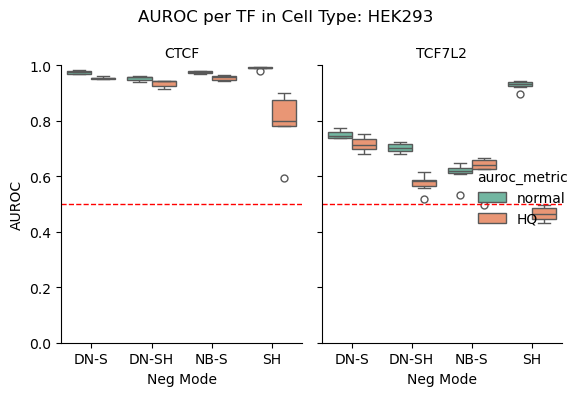

In [21]:
celltype = "HEK293"
# Filter the DataFrame for the current cell type
celltype_df = results_df[results_df['celltype'] == celltype]
mean_auroc_per_tf = celltype_df.groupby('TF')['AUROC'].mean().sort_values(ascending=False)
tf_order = mean_auroc_per_tf.index.tolist()

# Create a custom order for neg_sampling types
neg_sampling_order = ['dinucl_sampled', 'dinucl_shuffled', 'neighbors', 'shuffled']

# Sort the DataFrame by TF (using the custom order) and neg_sampling type
celltype_df['TF'] = pd.Categorical(celltype_df['TF'], categories=tf_order, ordered=True)
celltype_df['neg_mode'] = pd.Categorical(celltype_df['neg_mode'], categories=neg_sampling_order, ordered=True)
celltype_df = celltype_df.sort_values(['TF', 'neg_mode'])

# Create a new DataFrame with AUROC and AUROC_HQ combined into a single column
melted_df = pd.melt(
    celltype_df.sort_values(by=['TF', 'neg_mode']),
    id_vars=['TF', 'neg_mode'],
    value_vars=['AUROC', 'AUROC_HQ'],
    var_name='auroc_metric',
    value_name='AUROC_value'
)

# Map the metric names to more descriptive labels
melted_df['auroc_metric'] = melted_df['auroc_metric'].map({'AUROC': 'normal', 'AUROC_HQ': 'HQ'})

# Shorten neg_mode labels
neg_mode_labels = {
    'dinucl_sampled': 'DN-S',
    'dinucl_shuffled': 'DN-SH',
    'neighbors': 'NB-S',
    'shuffled': 'SH'
}

# Apply and order short labels
melted_df['neg_mode_short'] = melted_df['neg_mode'].map(neg_mode_labels)
neg_mode_order = ['DN-S', 'DN-SH', 'NB-S', 'SH']
melted_df['neg_mode_short'] = pd.Categorical(melted_df['neg_mode_short'], categories=neg_mode_order, ordered=True)

# Create the catplot
g = sns.catplot(
    data=melted_df,
    x='neg_mode_short',
    col='TF',
    y='AUROC_value',
    hue='auroc_metric',
    kind='box',
    height=4,
    aspect=0.6,
    palette='Set2'
)
g.set(ylim=(0, 1))
for ax in g.axes.flatten():
    ax.axhline(0.5, linestyle='--', color='red', linewidth=1)
# Titles and labels
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Neg Mode", "AUROC")

# Fix x-tick rotation manually
# for ax in g.axes.flatten():
#     for label in ax.get_xticklabels():
#         label.set_rotation(90)
#     ax.axhline(0.5, linestyle='--', color='red', linewidth=1)
g.fig.suptitle(f"AUROC per TF in Cell Type: {celltype}")
plt.tight_layout()
plt.show()

/tmp/ipykernel_854334/19365917.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  celltype_df['TF'] = pd.Categorical(celltype_df['TF'], categories=tf_order, ordered=True)
/tmp/ipykernel_854334/19365917.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  celltype_df['neg_mode'] = pd.Categorical(celltype_df['neg_mode'], categories=neg_sampling_order, ordered=True)


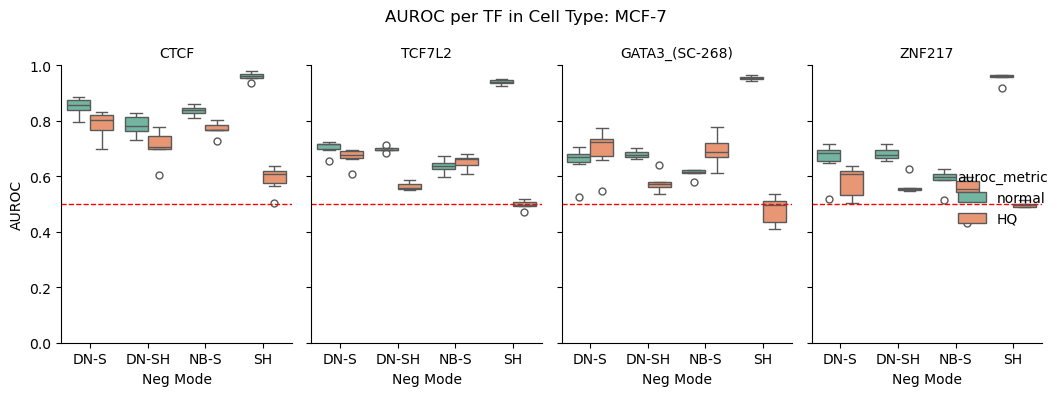

In [22]:
celltype = "MCF-7"
# Filter the DataFrame for the current cell type
celltype_df = results_df[results_df['celltype'] == celltype]
mean_auroc_per_tf = celltype_df.groupby('TF')['AUROC'].mean().sort_values(ascending=False)
tf_order = mean_auroc_per_tf.index.tolist()

# Create a custom order for neg_sampling types
neg_sampling_order = ['dinucl_sampled', 'dinucl_shuffled', 'neighbors', 'shuffled']

# Sort the DataFrame by TF (using the custom order) and neg_sampling type
celltype_df['TF'] = pd.Categorical(celltype_df['TF'], categories=tf_order, ordered=True)
celltype_df['neg_mode'] = pd.Categorical(celltype_df['neg_mode'], categories=neg_sampling_order, ordered=True)
celltype_df = celltype_df.sort_values(['TF', 'neg_mode'])

# Create a new DataFrame with AUROC and AUROC_HQ combined into a single column
melted_df = pd.melt(
    celltype_df.sort_values(by=['TF', 'neg_mode']),
    id_vars=['TF', 'neg_mode'],
    value_vars=['AUROC', 'AUROC_HQ'],
    var_name='auroc_metric',
    value_name='AUROC_value'
)

# Map the metric names to more descriptive labels
melted_df['auroc_metric'] = melted_df['auroc_metric'].map({'AUROC': 'normal', 'AUROC_HQ': 'HQ'})

# Shorten neg_mode labels
neg_mode_labels = {
    'dinucl_sampled': 'DN-S',
    'dinucl_shuffled': 'DN-SH',
    'neighbors': 'NB-S',
    'shuffled': 'SH'
}

# Apply and order short labels
melted_df['neg_mode_short'] = melted_df['neg_mode'].map(neg_mode_labels)
neg_mode_order = ['DN-S', 'DN-SH', 'NB-S', 'SH']
melted_df['neg_mode_short'] = pd.Categorical(melted_df['neg_mode_short'], categories=neg_mode_order, ordered=True)

# Create the catplot
g = sns.catplot(
    data=melted_df,
    x='neg_mode_short',
    col='TF',
    y='AUROC_value',
    hue='auroc_metric',
    kind='box',
    height=4,
    aspect=0.6,
    palette='Set2'
)
g.set(ylim=(0, 1))
for ax in g.axes.flatten():
    ax.axhline(0.5, linestyle='--', color='red', linewidth=1)
# Titles and labels
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Neg Mode", "AUROC")

# Fix x-tick rotation manually
# for ax in g.axes.flatten():
#     for label in ax.get_xticklabels():
#         label.set_rotation(90)
#     ax.axhline(0.5, linestyle='--', color='red', linewidth=1)
g.fig.suptitle(f"AUROC per TF in Cell Type: {celltype}")
plt.tight_layout()
plt.show()

In [23]:
results_df["AUROC_delta"] = results_df["AUROC"] - results_df["AUROC_HQ"]

/tmp/ipykernel_854334/3582006714.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  celltype_df['TF'] = pd.Categorical(celltype_df['TF'], categories=tf_order, ordered=True)
/tmp/ipykernel_854334/3582006714.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  celltype_df['neg_mode'] = pd.Categorical(celltype_df['neg_mode'], categories=neg_sampling_order, ordered=True)


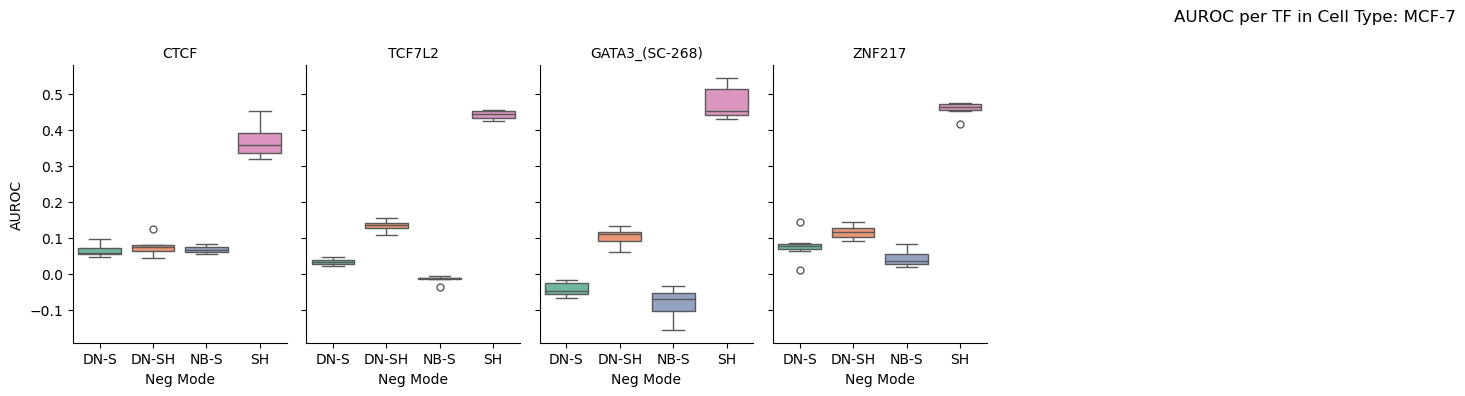

/tmp/ipykernel_854334/3582006714.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  celltype_df['TF'] = pd.Categorical(celltype_df['TF'], categories=tf_order, ordered=True)
/tmp/ipykernel_854334/3582006714.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  celltype_df['neg_mode'] = pd.Categorical(celltype_df['neg_mode'], categories=neg_sampling_order, ordered=True)


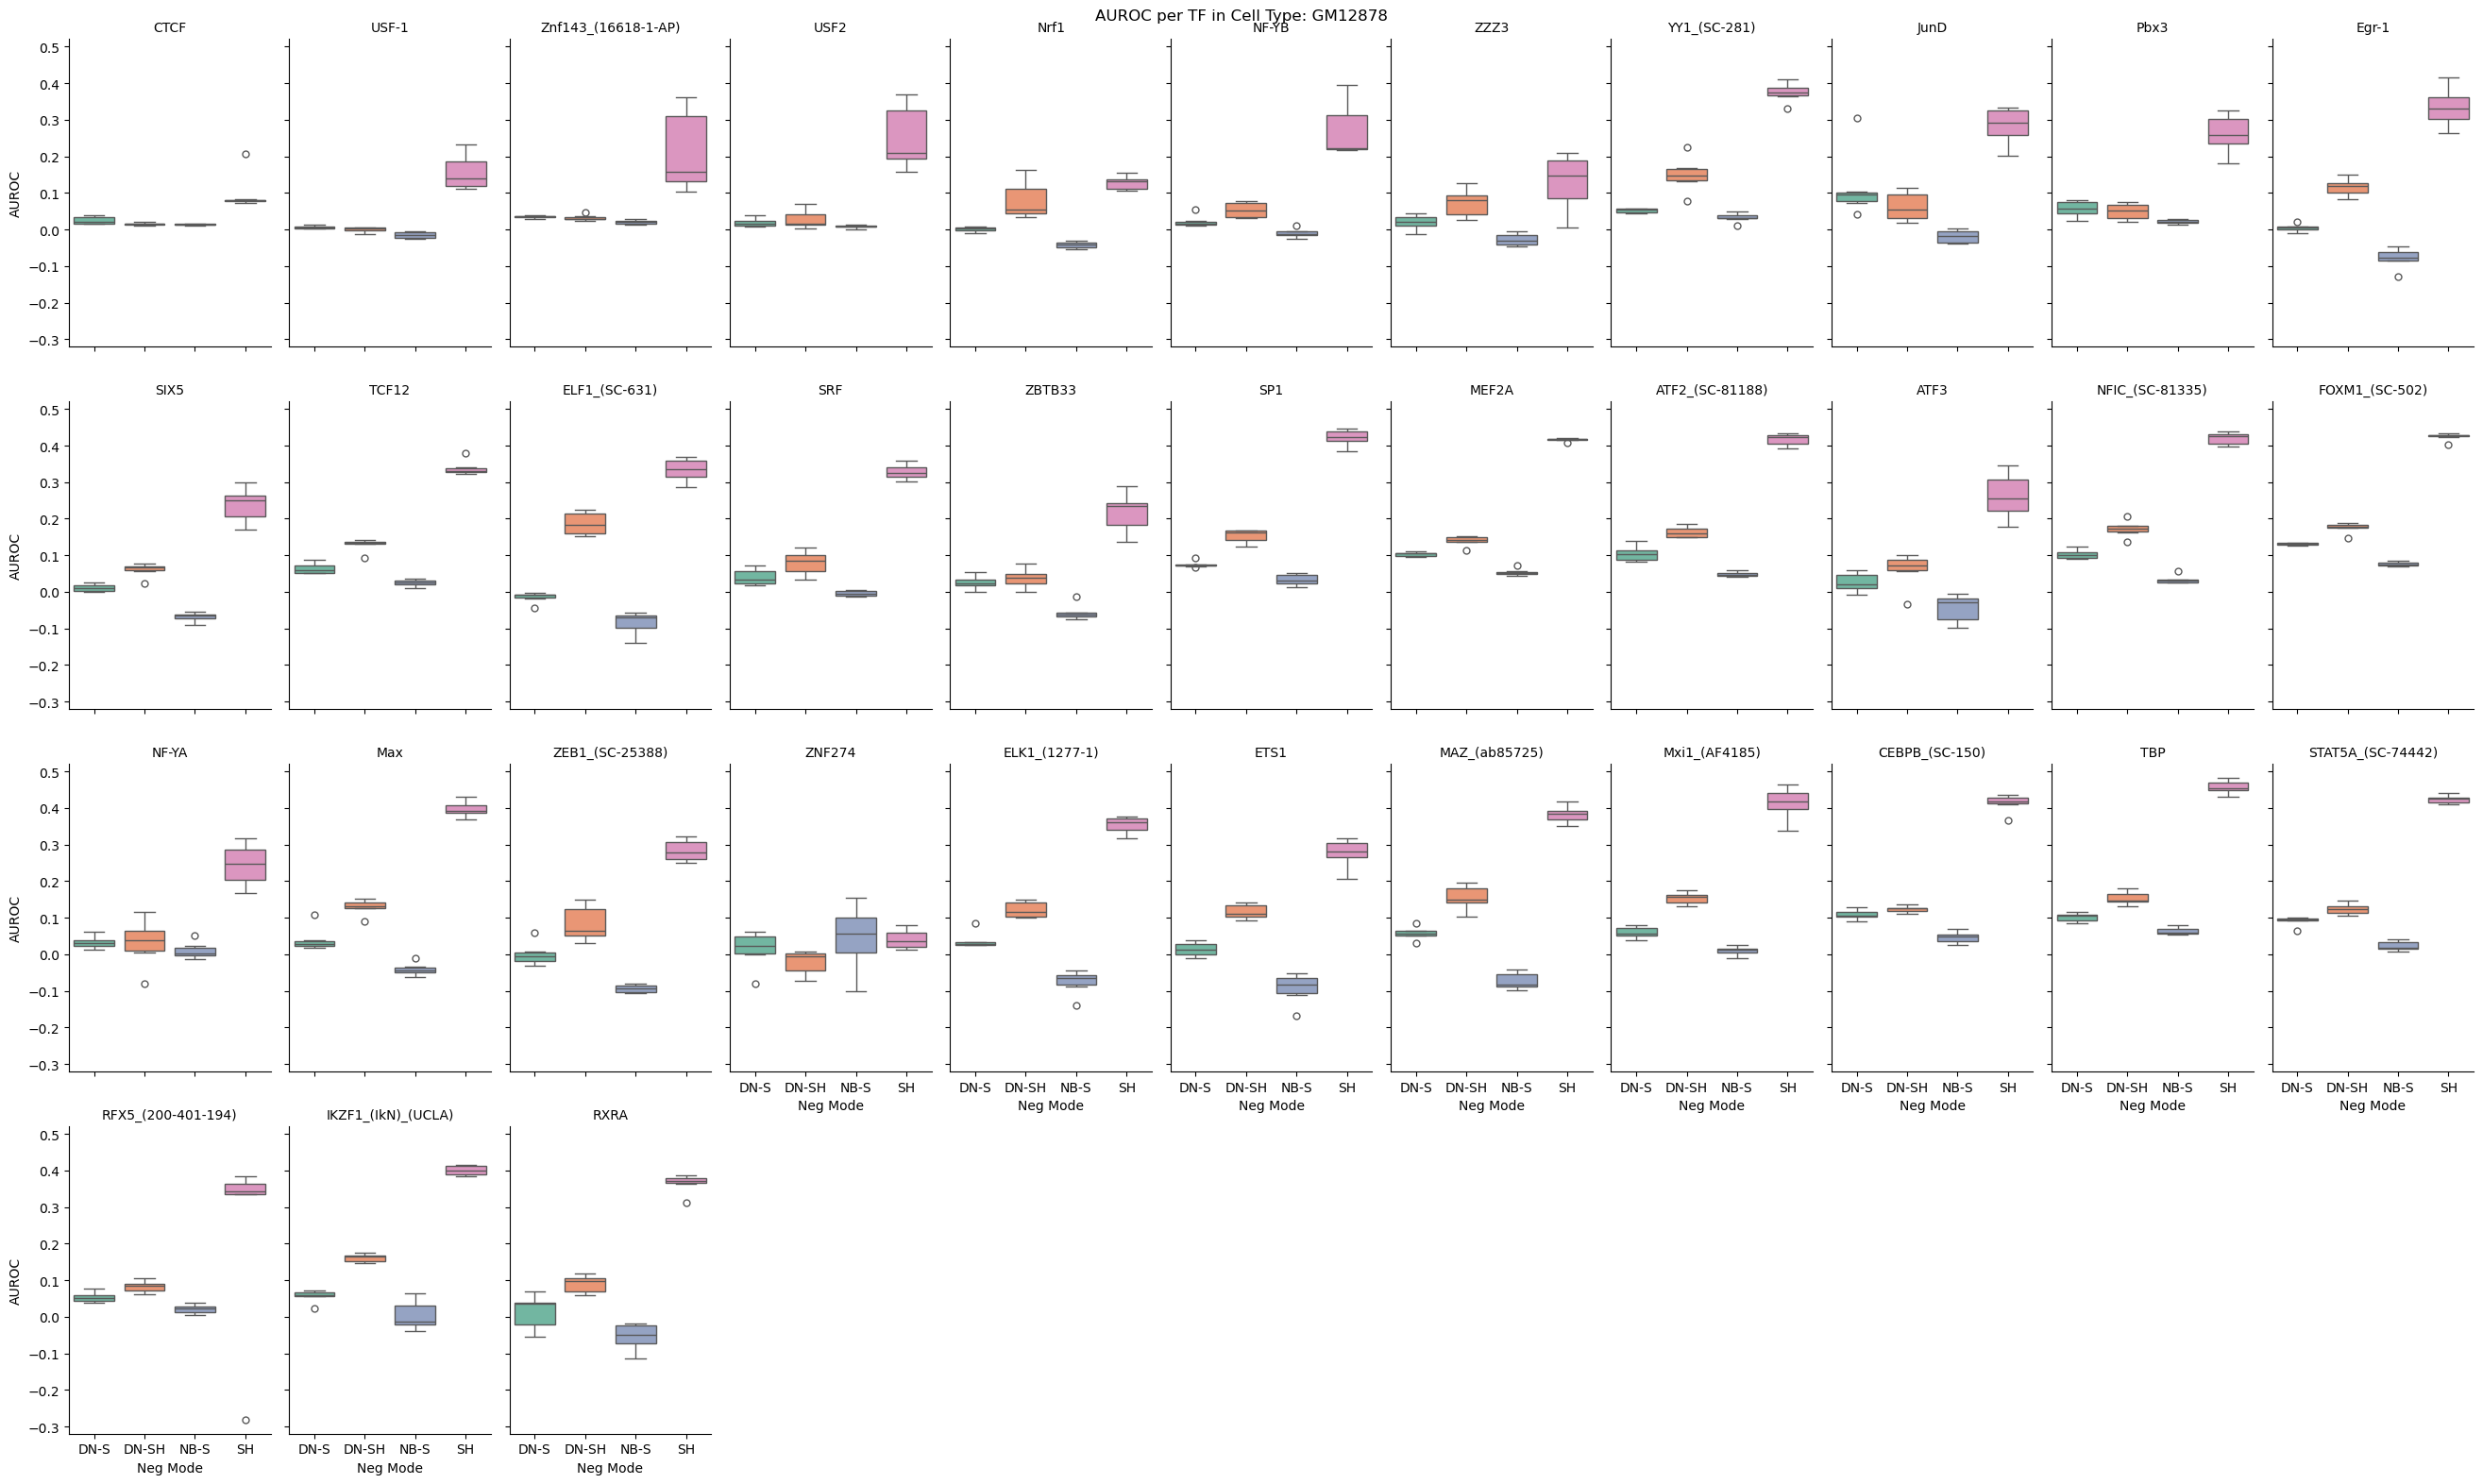

/tmp/ipykernel_854334/3582006714.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  celltype_df['TF'] = pd.Categorical(celltype_df['TF'], categories=tf_order, ordered=True)
/tmp/ipykernel_854334/3582006714.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  celltype_df['neg_mode'] = pd.Categorical(celltype_df['neg_mode'], categories=neg_sampling_order, ordered=True)


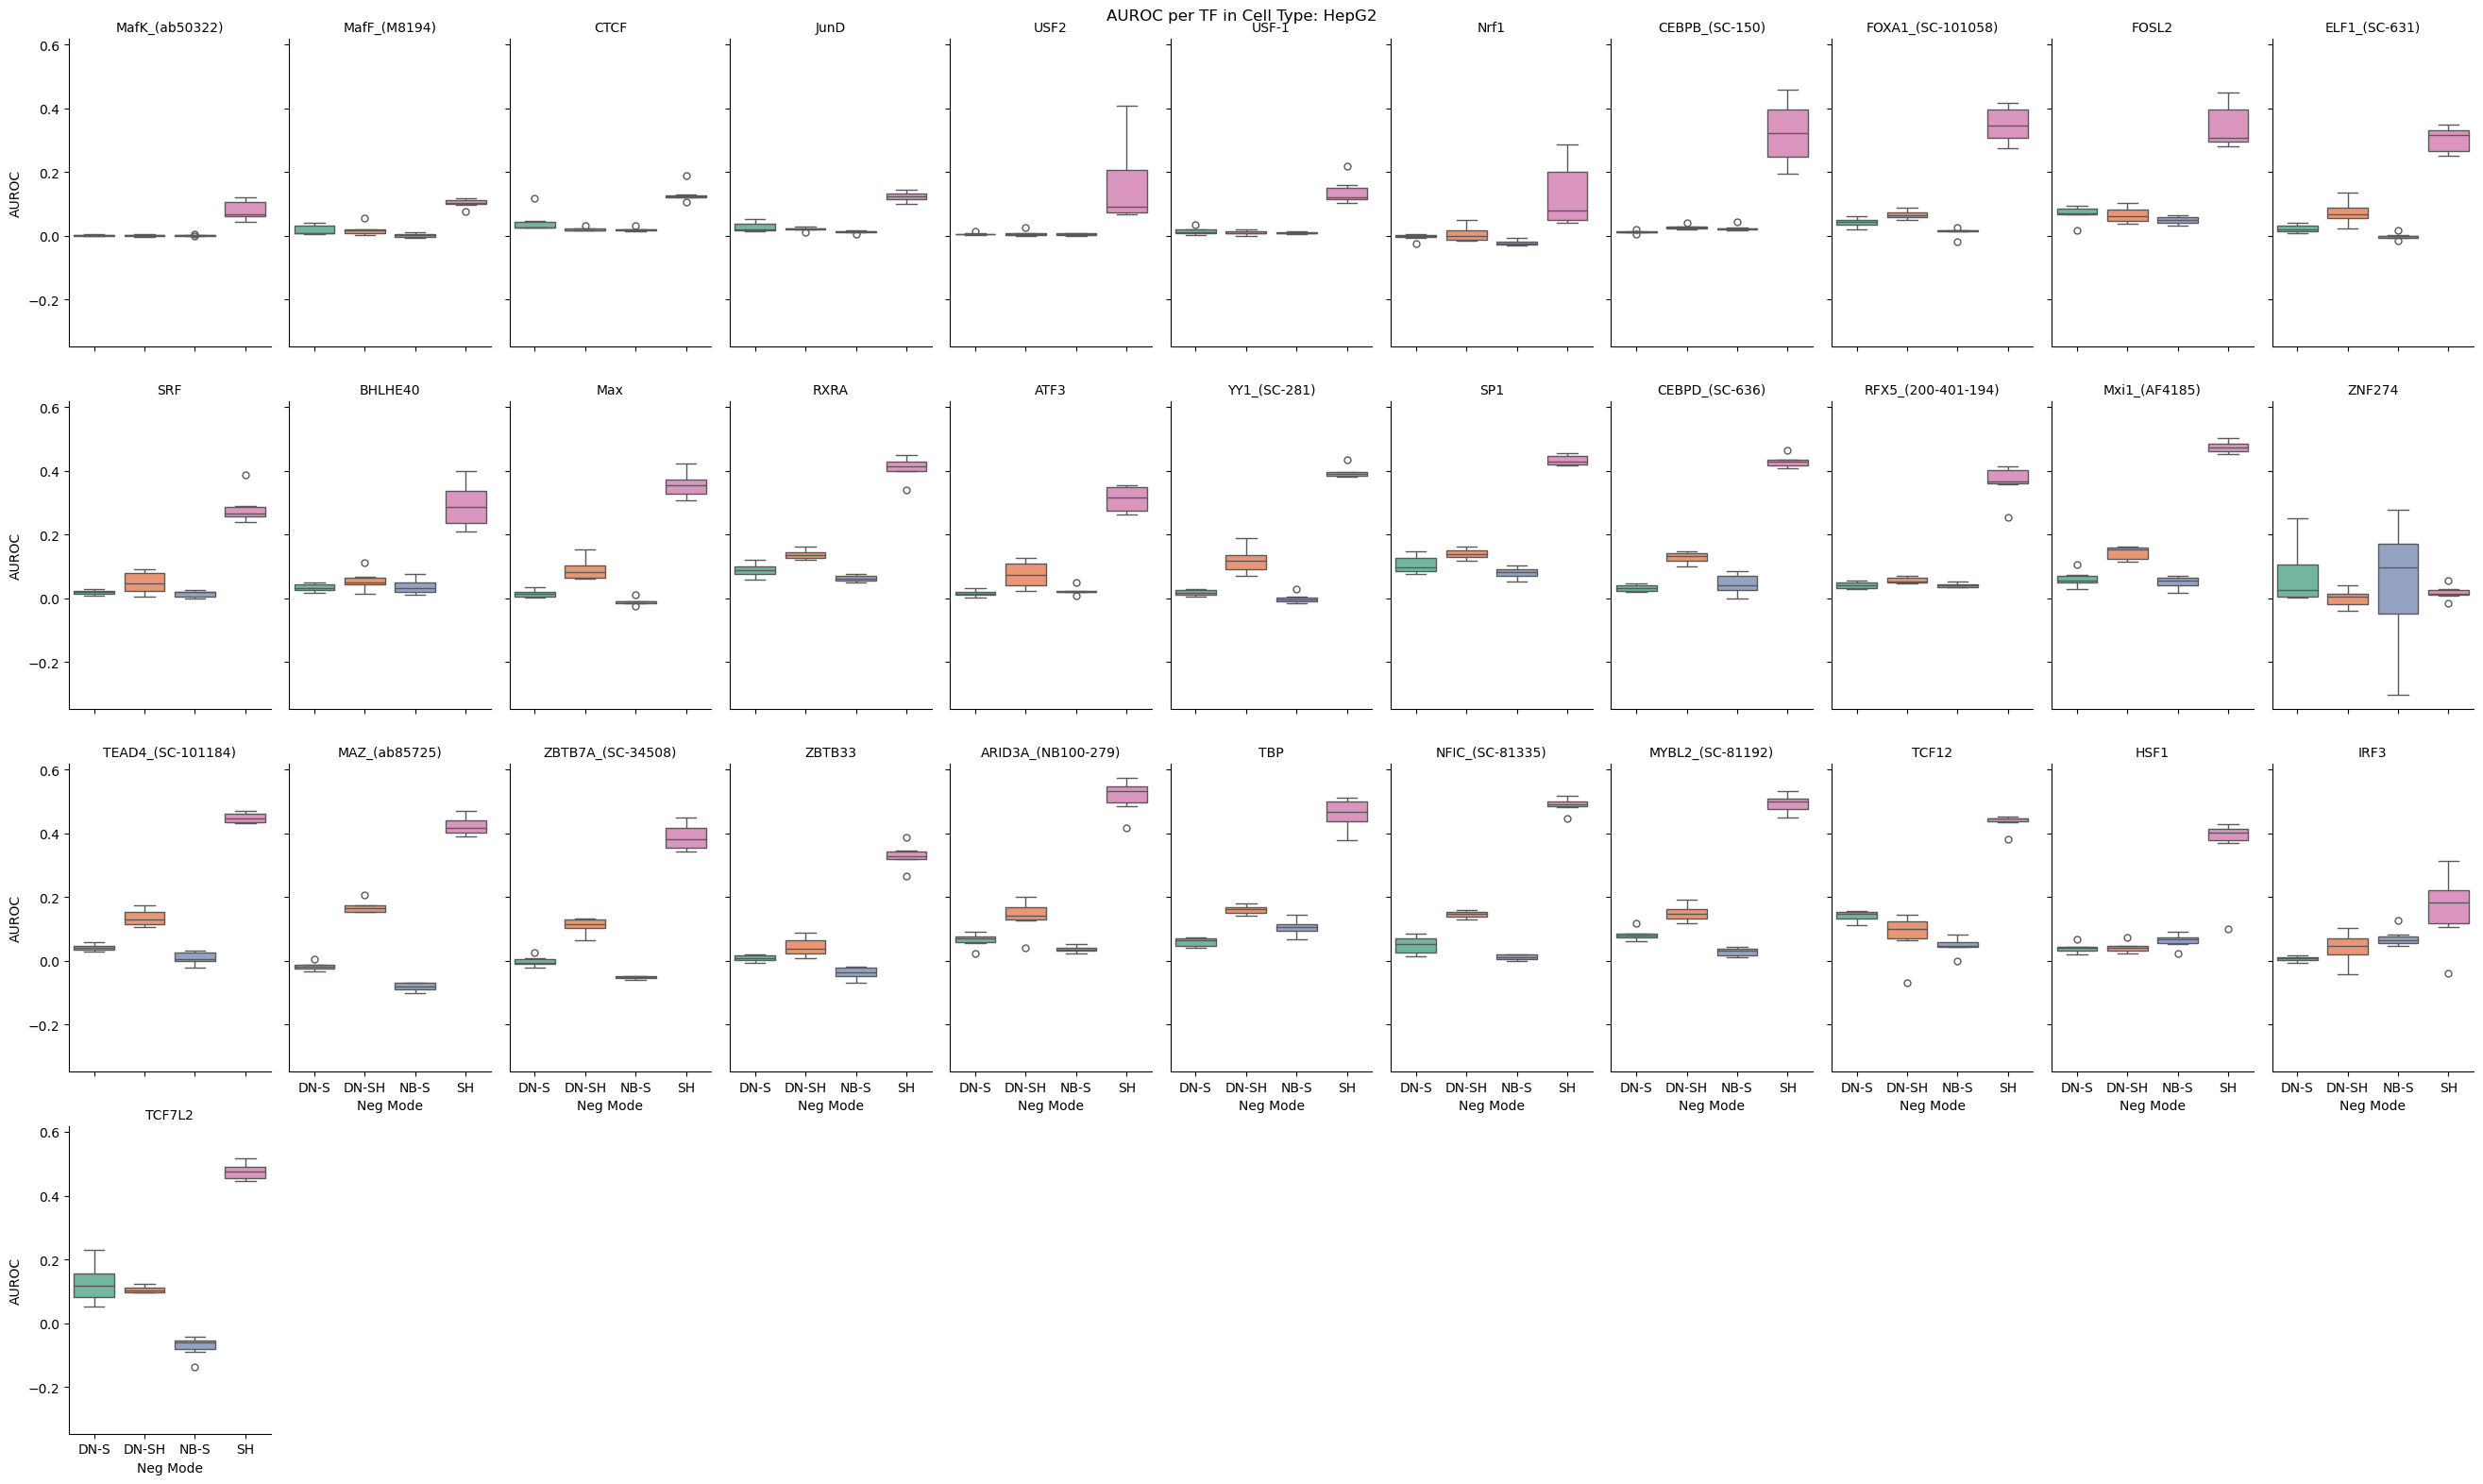

/tmp/ipykernel_854334/3582006714.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  celltype_df['TF'] = pd.Categorical(celltype_df['TF'], categories=tf_order, ordered=True)
/tmp/ipykernel_854334/3582006714.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  celltype_df['neg_mode'] = pd.Categorical(celltype_df['neg_mode'], categories=neg_sampling_order, ordered=True)


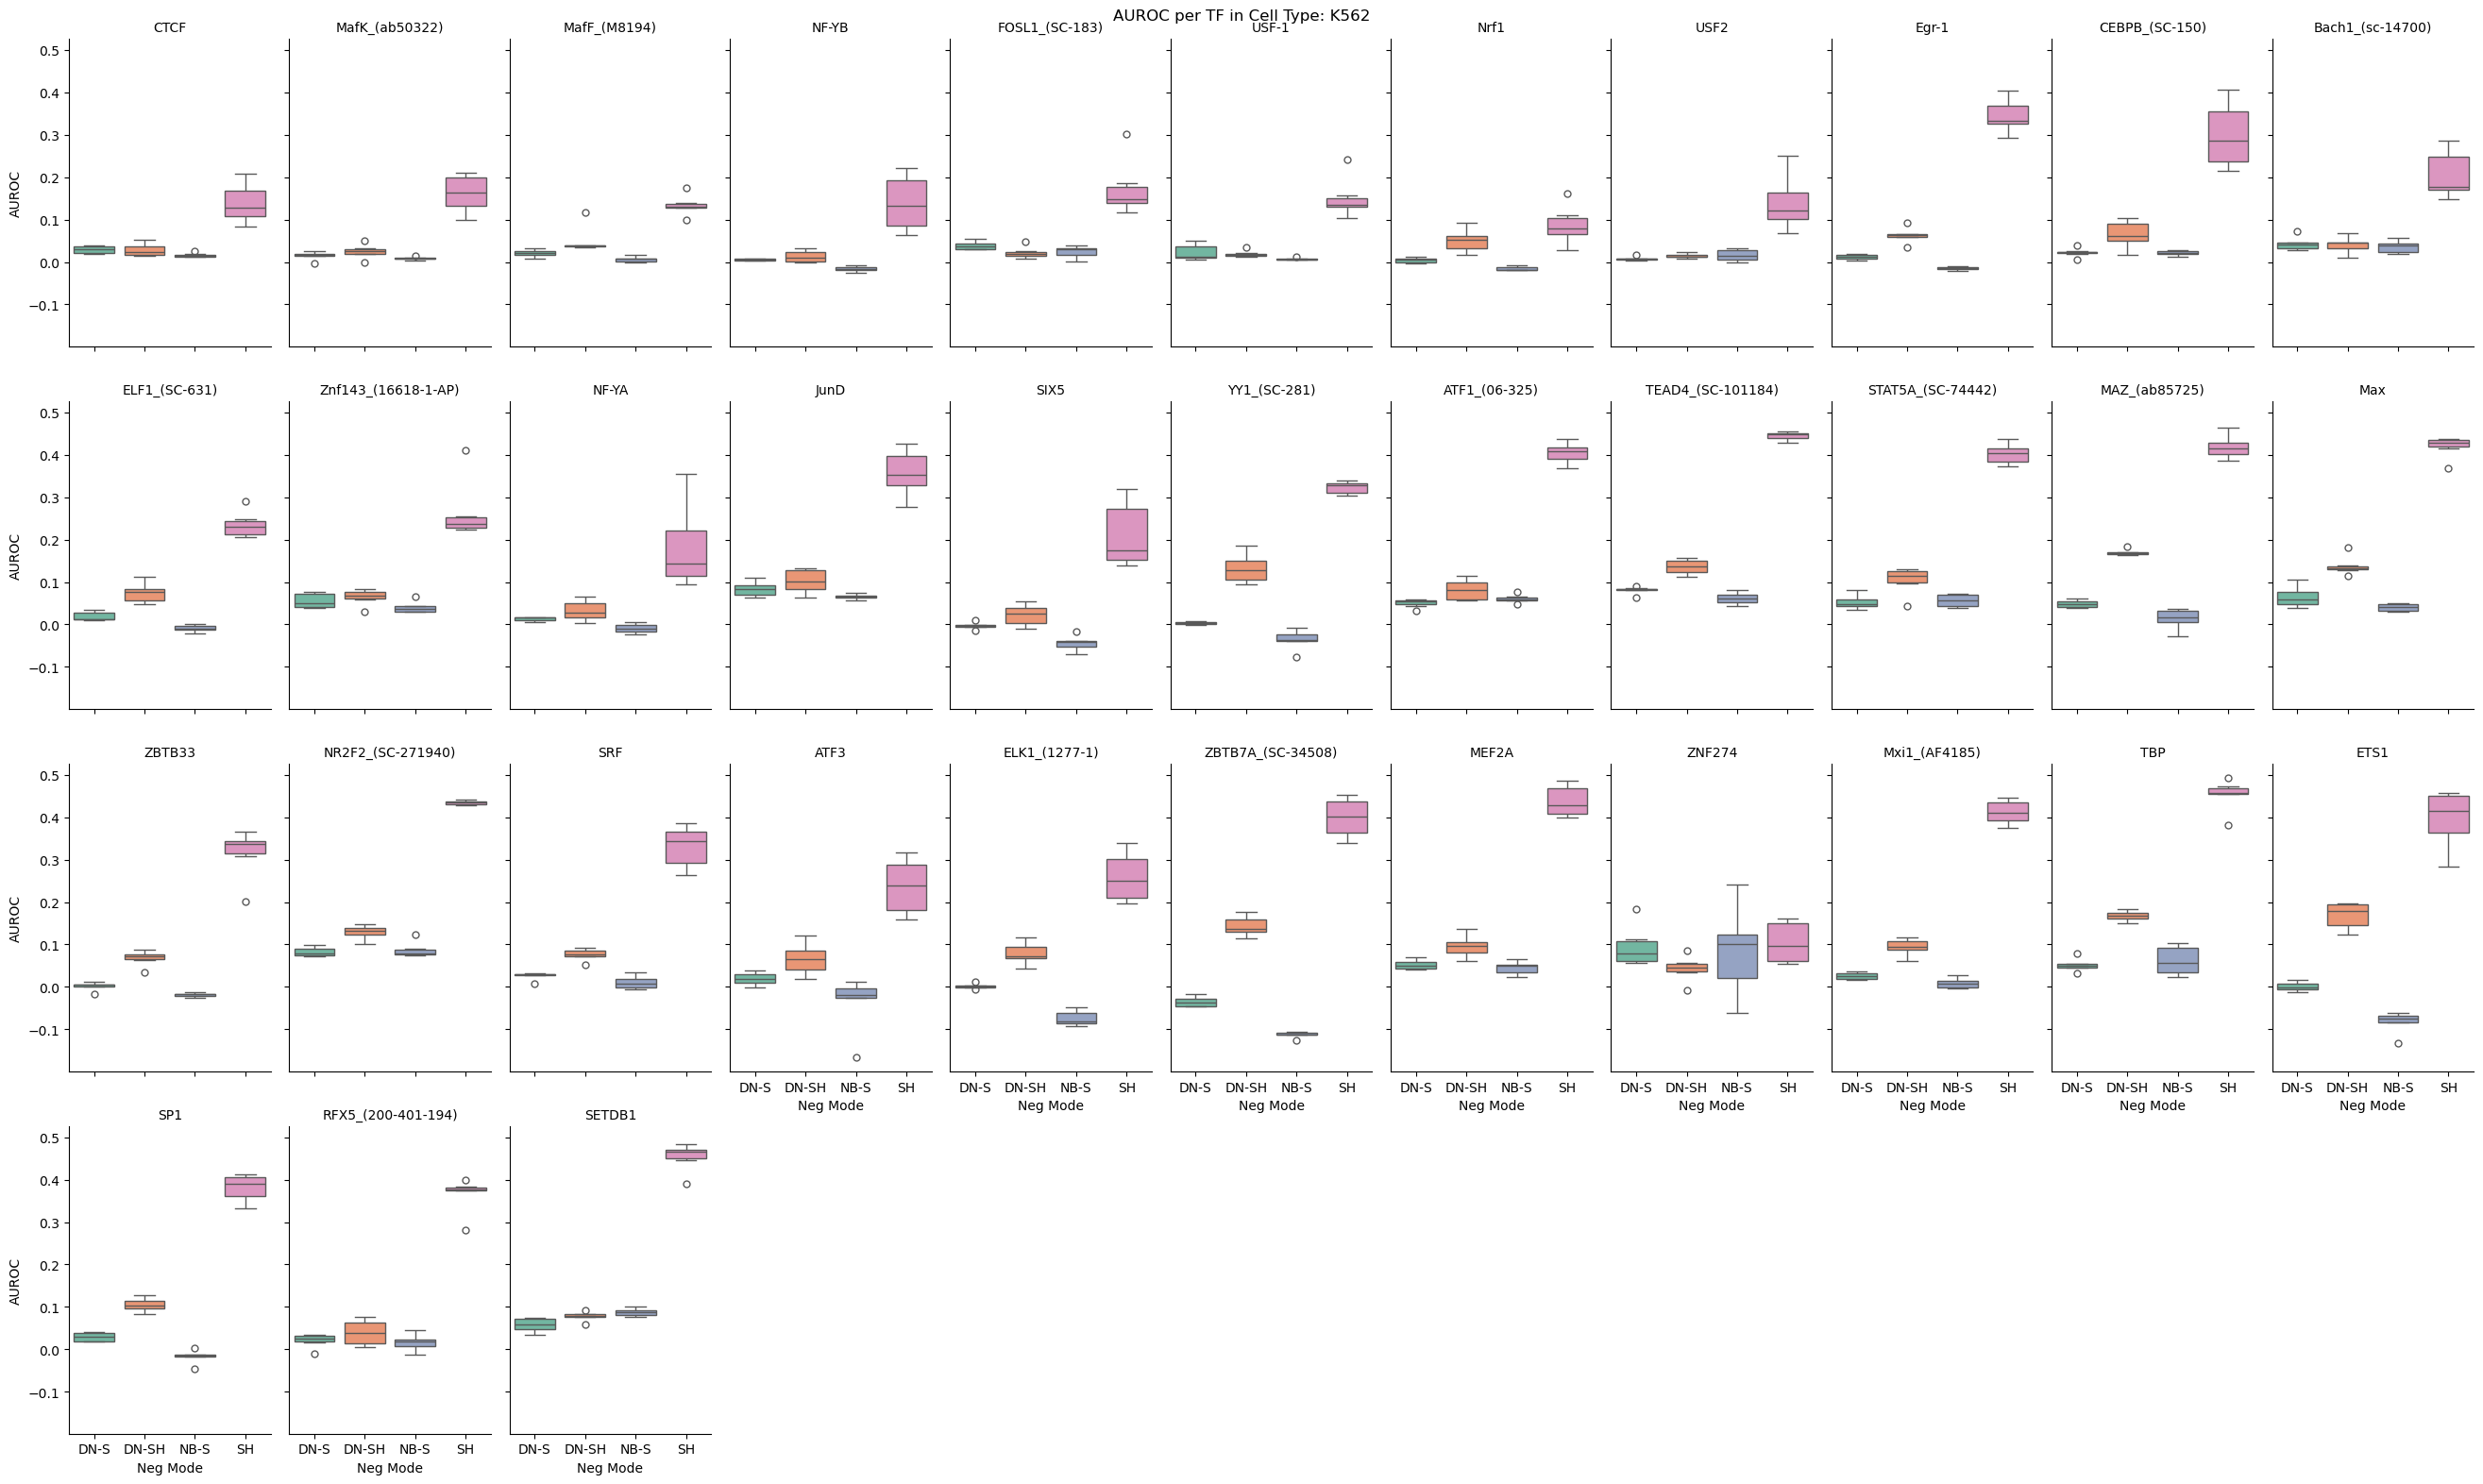

/tmp/ipykernel_854334/3582006714.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  celltype_df['TF'] = pd.Categorical(celltype_df['TF'], categories=tf_order, ordered=True)
/tmp/ipykernel_854334/3582006714.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  celltype_df['neg_mode'] = pd.Categorical(celltype_df['neg_mode'], categories=neg_sampling_order, ordered=True)


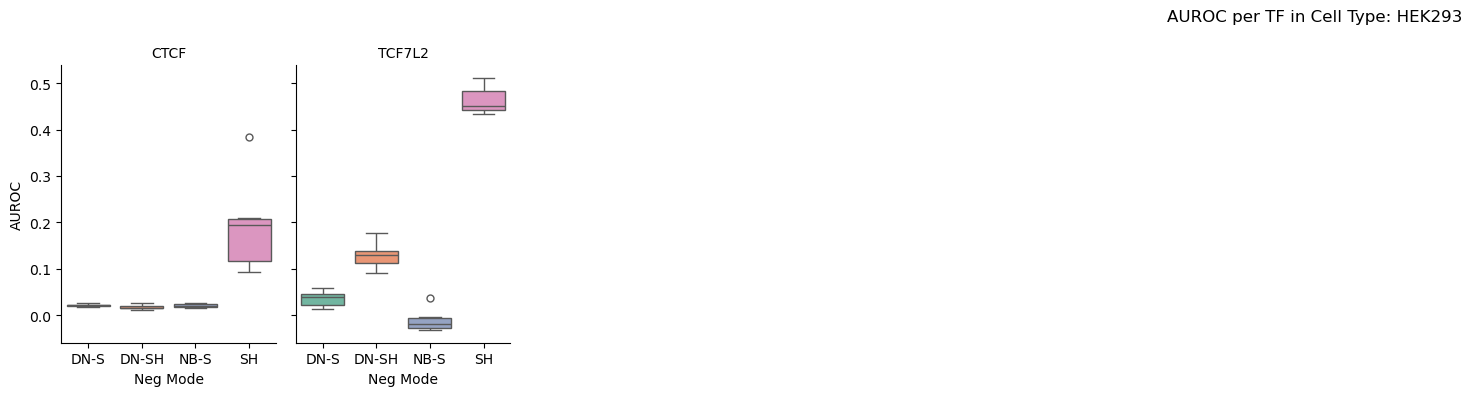

/tmp/ipykernel_854334/3582006714.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  celltype_df['TF'] = pd.Categorical(celltype_df['TF'], categories=tf_order, ordered=True)
/tmp/ipykernel_854334/3582006714.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  celltype_df['neg_mode'] = pd.Categorical(celltype_df['neg_mode'], categories=neg_sampling_order, ordered=True)


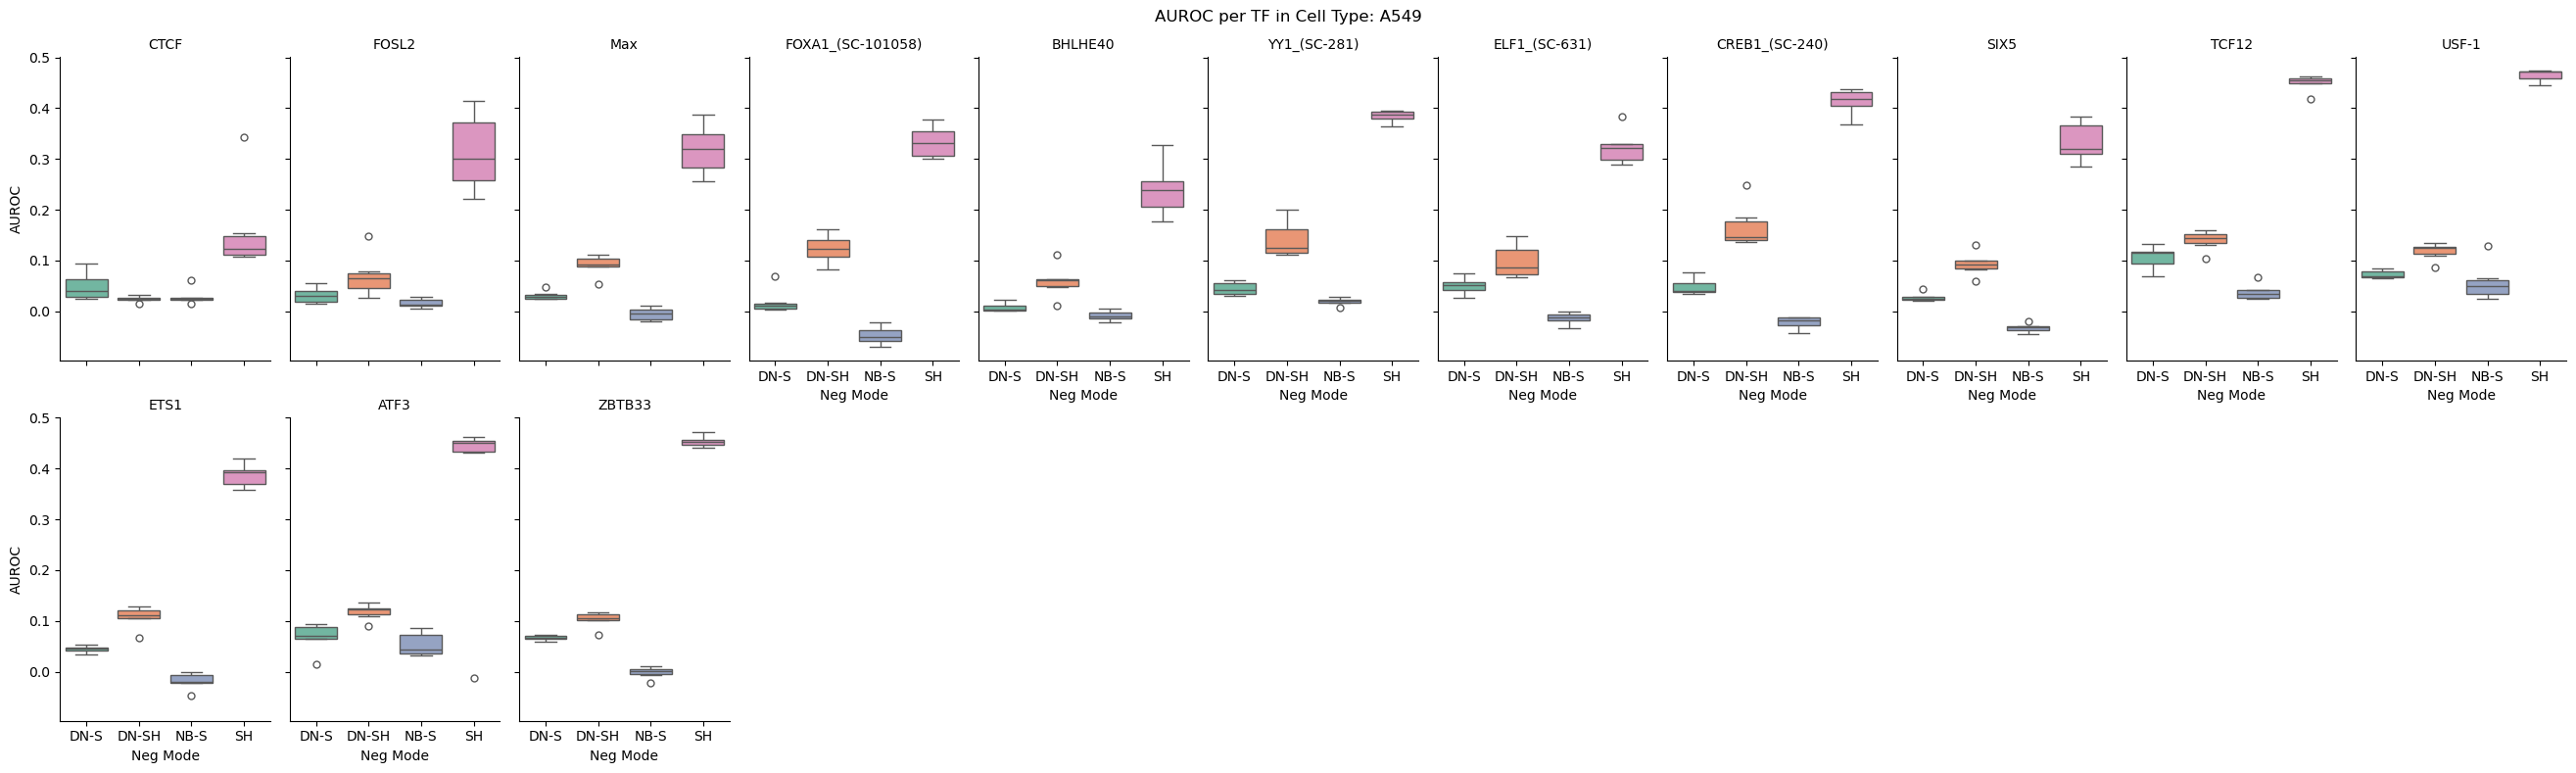

In [24]:
# WRONG FIGURES! STILL NEED TO FIX THEM
import matplotlib.pyplot as plt
import seaborn as sns
unique_celltypes = results_df["celltype"].unique().tolist()
for celltype in unique_celltypes:
    # Filter the DataFrame for the current cell type
    celltype_df = results_df[results_df['celltype'] == celltype]
    mean_auroc_per_tf = celltype_df.groupby('TF')['AUROC'].mean().sort_values(ascending=False)
    tf_order = mean_auroc_per_tf.index.tolist()

    # Create a custom order for neg_sampling types
    neg_sampling_order = ['dinucl_sampled', 'dinucl_shuffled', 'neighbors', 'shuffled']

    # Sort the DataFrame by TF (using the custom order) and neg_sampling type
    celltype_df['TF'] = pd.Categorical(celltype_df['TF'], categories=tf_order, ordered=True)
    celltype_df['neg_mode'] = pd.Categorical(celltype_df['neg_mode'], categories=neg_sampling_order, ordered=True)
    celltype_df = celltype_df.sort_values(['TF', 'neg_mode'])


    # Shorten neg_mode labels
    neg_mode_labels = {
        'dinucl_sampled': 'DN-S',
        'dinucl_shuffled': 'DN-SH',
        'neighbors': 'NB-S',
        'shuffled': 'SH'
    }

    # Apply and order short labels
    celltype_df['neg_mode_short'] = celltype_df['neg_mode'].map(neg_mode_labels)
    neg_mode_order = ['DN-S', 'DN-SH', 'NB-S', 'SH']
    celltype_df['neg_mode_short'] = pd.Categorical(celltype_df['neg_mode_short'], categories=neg_mode_order, ordered=True)

    # Create the catplot
    g = sns.catplot(
        data=celltype_df,
        x='neg_mode_short',
        col='TF',
        y='AUROC_delta',
        hue='neg_mode_short',
        kind='box',
        col_wrap=11,
        height=4,
        aspect=0.6,
        palette='Set2'
    )

    # Titles and labels
    g.set_titles(col_template="{col_name}")
    g.set_axis_labels("Neg Mode", "AUROC")

    # Fix x-tick rotation manually
    # for ax in g.axes.flatten():
    #     for label in ax.get_xticklabels():
    #         label.set_rotation(90)
    #     ax.axhline(0.5, linestyle='--', color='red', linewidth=1)
    g.fig.suptitle(f"AUROC per TF in Cell Type: {celltype}")
    plt.tight_layout()
    plt.show()

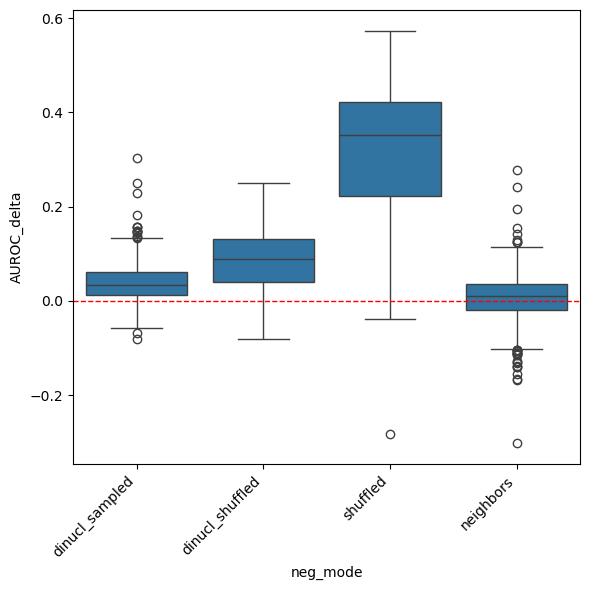

In [25]:
plt.figure(figsize=(6, 6))
# Create the boxplot
sns.boxplot(data=results_df, x='neg_mode', y='AUROC_delta')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)

# Adjust plot aesthetics
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

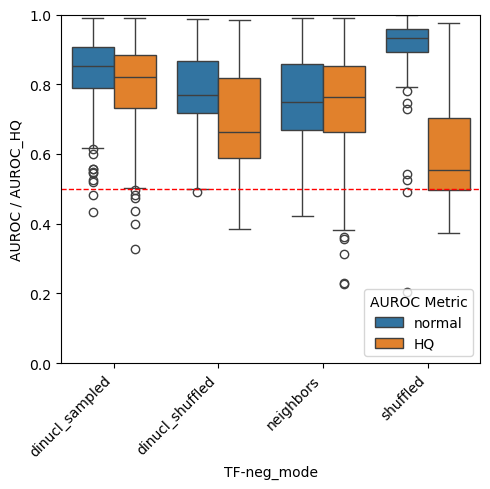

In [26]:
# Create the boxplot for AUROC
plt.figure(figsize=(5, 5))

# Create a new DataFrame with AUROC and AUROC_HQ combined into a single column
melted_df = pd.melt(
    results_df.sort_values(by=['TF-neg_mode']),
    id_vars=['neg_mode'],
    value_vars=['AUROC', 'AUROC_HQ'],
    var_name='auroc_metric',
    value_name='AUROC_value'
)

# Map the metric names to more descriptive labels
melted_df['auroc_metric'] = melted_df['auroc_metric'].map({'AUROC': 'normal', 'AUROC_HQ': 'HQ'})


# Create the boxplot
sns.boxplot(data=melted_df, x='neg_mode', y='AUROC_value', hue='auroc_metric')



# Add a horizontal line at y=0.5
plt.axhline(y=0.5, color='red', linestyle='--', linewidth=1)

# Adjust legend
plt.legend(title='AUROC Metric', loc='lower right')

# Adjust plot aesthetics
plt.xticks(rotation=45, ha='right')
plt.xlabel('TF-neg_mode')

plt.ylabel('AUROC / AUROC_HQ')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


In [27]:
import os

# Define the folder path
folder_path = "/data/home/natant/Negatives/Runs/full_run_1/motifs"

# Get a list of all CSV files in the folder
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# Load each CSV file into a dictionary of DataFrames
dataframes = {os.path.splitext(f)[0]: pd.read_csv(os.path.join(folder_path, f)) for f in csv_files}
dataframes = {name: df.rename(columns={"Unnamed: 0": "TF"}) for name, df in dataframes.items()}

# Print the names of the loaded DataFrames
print(f"Loaded DataFrames: {list(dataframes.keys())}")

Loaded DataFrames: ['HEK293', 'MCF-7', 'A549', 'GM12878', 'K562', 'HepG2']


In [28]:
# Initialize an empty list to store DataFrames
merged_dfs = []

# Iterate through the CSV files and process each one
for celltype in csv_files:
    # Extract the cell type name (without the .csv extension)
    celltype_name = os.path.splitext(celltype)[0]
    
    # Load the DataFrame for the current cell type
    df = pd.melt(
        dataframes[celltype_name],
        id_vars=['TF'],
        value_vars=['AUROC_1', 'AUROC_2', 'AUROC_3'],
        value_name='AUROC'
    )
    
    # Drop unnecessary columns and rows with NaN values
    df = df.dropna().drop(columns=['variable'])
    
    # Add additional columns for cell type and neg_mode
    df['celltype'] = celltype_name
    df['neg_mode'] = 'motif'
    
    # Append the processed DataFrame to the list
    merged_dfs.append(df)

# Concatenate all the DataFrames into a single DataFrame
motif_df = pd.concat(merged_dfs, ignore_index=True)

In [54]:
subset_df = results_df[(results_df['celltype'].isin(motif_df["celltype"].unique())) & (results_df['TF'].isin(motif_df['TF'].unique()))]
# Concatenate subset_df and melted_df, keeping only the specified columns
subset_df = subset_df[['TF', 'AUROC_HQ', 'neg_mode', 'celltype']]
subset_df = subset_df.rename(columns={"AUROC_HQ": "AUROC"})
fused_df = pd.concat([subset_df[['TF', 'AUROC', 'neg_mode', 'celltype']], motif_df[['TF', 'AUROC', 'neg_mode', 'celltype']]])

# Reset the index for the new DataFrame
fused_df.reset_index(drop=True, inplace=True)


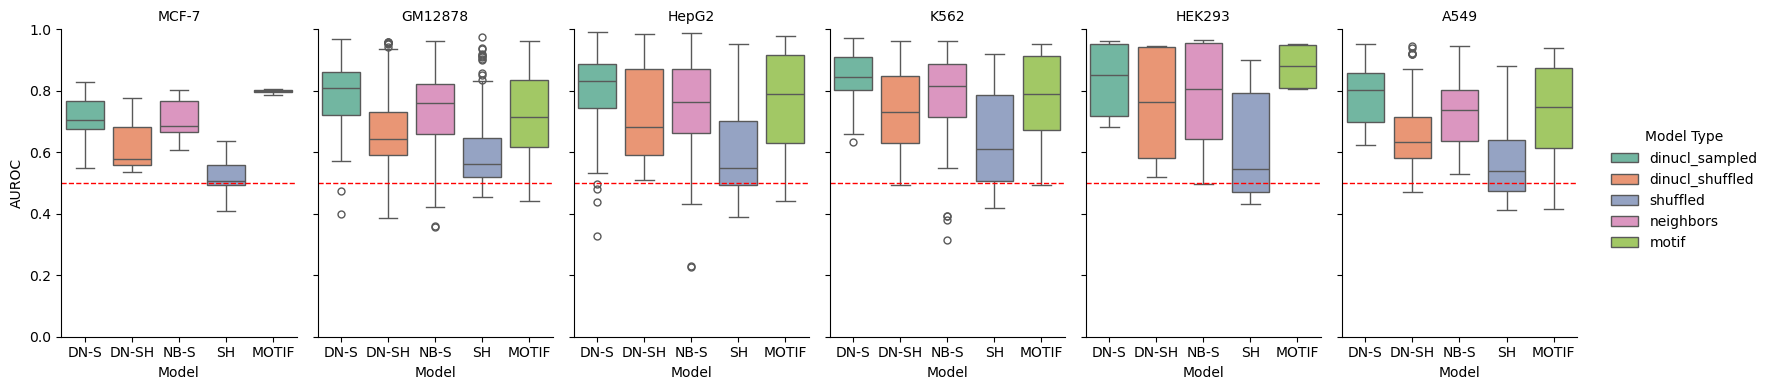

In [55]:
# Shorten neg_mode labels
neg_mode_labels = {
    'dinucl_sampled': 'DN-S',
    'dinucl_shuffled': 'DN-SH',
    'neighbors': 'NB-S',
    'shuffled': 'SH',
    'motif': "MOTIF"
}

# Apply and order short labels
fused_df['neg_mode_short'] = fused_df['neg_mode'].map(neg_mode_labels)
neg_mode_order = ['DN-S', 'DN-SH', 'NB-S', 'SH', 'MOTIF']
fused_df['neg_mode_short'] = pd.Categorical(fused_df['neg_mode_short'], categories=neg_mode_order, ordered=True)

g = sns.catplot(
        data=fused_df,
        x='neg_mode_short',
        col='celltype',
        y='AUROC',
        hue='neg_mode',
        kind='box',
        height=4,
        aspect=0.6,
        palette='Set2'
    )
# Titles and labels
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Model", "AUROC")

# Fix x-tick rotation manually
# for ax in g.axes.flatten():
#     for label in ax.get_xticklabels():
#         label.set_rotation(90)
#     ax.axhline(0.5, linestyle='--', color='red', linewidth=1)
# Adjust legend placement to avoid overlapping
g._legend.set_bbox_to_anchor((1, 0.5))
g._legend.set_loc("center left")
# Rename the legend title
g._legend.set_title("Model Type")

# Scale the y-axis from 0 to 1
g.set(ylim=(0, 1))

# Add a red line at y=0.5
for ax in g.axes.flatten():
    ax.axhline(0.5, linestyle='--', color='red', linewidth=1)
plt.tight_layout()
plt.show()

## Checking HQ data (only for 1 celltype right now)

In [46]:
HQ_results

,run_name,TF,celltype,neg_mode,cross_val_set,group_name,AUROC,AUROC_HQ,val_loss,neg_mode_short
7879,decent-flower-8188,CTCF,MCF-7,HQ training,3.0,full_run_2_HQ,0.724047,NaN,0.481008,HQ training
7880,amber-paper-8189,CTCF,MCF-7,HQ training,2.0,full_run_2_HQ,0.652220,NaN,0.330517,HQ training
7881,upbeat-bee-8189,CTCF,MCF-7,HQ training,1.0,full_run_2_HQ,0.640582,NaN,0.288998,HQ training
7882,solar-aardvark-8191,CTCF,MCF-7,HQ training,0.0,full_run_2_HQ,0.774218,NaN,0.608637,HQ training
7883,effortless-waterfall-8192,CTCF,MCF-7,HQ training,4.0,full_run_2_HQ,0.827228,NaN,0.744126,HQ training
...,...,...,...,...,...,...,...,...,...,...
8630,devoted-disco-8939,FOXA1_(SC-101058),A549,HQ training,1.0,full_run_2_HQ,0.898555,NaN,0.203561,HQ training
8631,polar-spaceship-8940,FOXA1_(SC-101058),A549,HQ training,2.0,full_run_2_HQ,0.882095,NaN,0.306169,HQ training
8632,giddy-sponge-8941,FOXA1_(SC-101058),A549,HQ training,3.0,full_run_2_HQ,0.884764,NaN,0.154074,HQ training
8633,wobbly-energy-8942,FOXA1_(SC-101058),A549,HQ training,4.0,full_run_2_HQ,0.799165,NaN,0.102044,HQ training


In [57]:
# Concatenate HQ_results with results_df
combined_results = pd.concat([results_df, HQ_results], ignore_index=True)

# If you want to include it in fused_df, ensure the columns match
HQ_results['neg_mode_short'] = "HQ training"  # Add the short label for neg_mode
all_fused_df = pd.concat([fused_df, HQ_results[['TF', 'AUROC', 'neg_mode', 'celltype', 'neg_mode_short']]], ignore_index=True)

# Reset the index for consistency
all_fused_df.reset_index(drop=True, inplace=True)

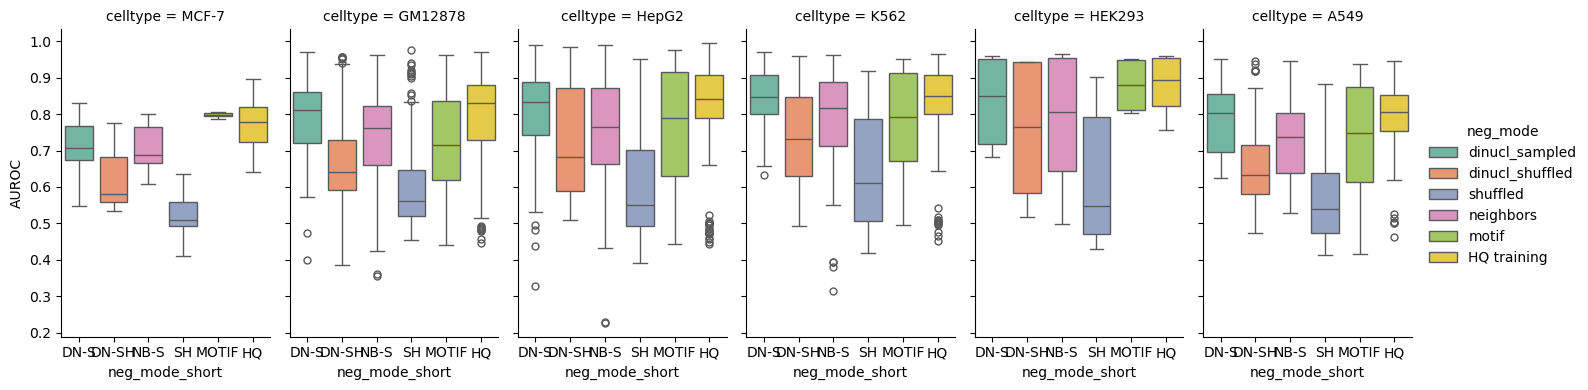

In [60]:
# Shorten neg_mode labels
neg_mode_labels = {
    'dinucl_sampled': 'DN-S',
    'dinucl_shuffled': 'DN-SH',
    'neighbors': 'NB-S',
    'shuffled': 'SH',
    'motif': "MOTIF",
    'HQ training': "HQ"
}

# Apply and order short labels
all_fused_df['neg_mode_short'] = all_fused_df['neg_mode'].map(neg_mode_labels)
neg_mode_order = ['DN-S', 'DN-SH', 'NB-S', 'SH', 'MOTIF', 'HQ']


#fused_df = pd.concat([fused_df, HQ_results_melted.rename(columns={"AUROC_value": "AUROC"}).drop(columns=["auroc_metric"])], ignore_index=True) #! adding the HQ results
all_fused_df['neg_mode_short'] = pd.Categorical(all_fused_df['neg_mode_short'], categories=neg_mode_order, ordered=True)

g = sns.catplot(
        data=all_fused_df,
        x='neg_mode_short',
        col='celltype',
        y='AUROC',
        hue='neg_mode',
        kind='box',
        height=4,
        aspect=0.6,
        palette='Set2'
    )

In [ ]:
# HQ_results_melted= HQ_results[["TF", "neg_mode", "AUROC"]]
# HQ_results_melted = HQ_results_melted.rename(columns={"AUROC": "AUROC_value"})
# HQ_results_melted["neg_mode_short"] = "HQ"
# HQ_results_melted["auroc_metric"] = "HQ (t)"

In [51]:
# celltype = "A549"
# # Filter the DataFrame for the current cell type
# celltype_df = results_df[results_df['celltype'] == celltype]
# mean_auroc_per_tf = celltype_df.groupby('TF')['AUROC'].mean().sort_values(ascending=False)
# tf_order = mean_auroc_per_tf.index.tolist()

# # Create a custom order for neg_sampling types
# neg_sampling_order = ['dinucl_sampled', 'dinucl_shuffled', 'neighbors', 'shuffled']

# # Sort the DataFrame by TF (using the custom order) and neg_sampling type
# celltype_df['TF'] = pd.Categorical(celltype_df['TF'], categories=tf_order, ordered=True)
# celltype_df['neg_mode'] = pd.Categorical(celltype_df['neg_mode'], categories=neg_sampling_order, ordered=True)
# celltype_df = celltype_df.sort_values(['TF', 'neg_mode'])

# # Create a new DataFrame with AUROC and AUROC_HQ combined into a single column
# melted_df = pd.melt(
#     celltype_df.sort_values(by=['TF', 'neg_mode']),
#     id_vars=['TF', 'neg_mode'],
#     value_vars=['AUROC', 'AUROC_HQ'],
#     var_name='auroc_metric',
#     value_name='AUROC_value'
# )

# # Map the metric names to more descriptive labels
# melted_df['auroc_metric'] = melted_df['auroc_metric'].map({'AUROC': 'normal', 'AUROC_HQ': 'HQ'})

# # Shorten neg_mode labels
# neg_mode_labels = {
#     'dinucl_sampled': 'DN-S',
#     'dinucl_shuffled': 'DN-SH',
#     'neighbors': 'NB-S',
#     'shuffled': 'SH'
# }

# # Apply and order short labels
# melted_df['neg_mode_short'] = melted_df['neg_mode'].map(neg_mode_labels)
# neg_mode_order = ['DN-S', 'DN-SH', 'NB-S', 'SH', "HQ"]

# melted_df = pd.concat([melted_df, HQ_results_melted], ignore_index=True) #! adding the HQ results
# melted_df['neg_mode_short'] = pd.Categorical(melted_df['neg_mode_short'], categories=neg_mode_order, ordered=True)

# # Create the catplot
# g = sns.catplot(
#     data=melted_df,
#     x='neg_mode_short',
#     col='TF',
#     y='AUROC_value',
#     hue='auroc_metric',
#     kind='box',
#     col_wrap=7,
#     height=4,
#     aspect=0.6,
#     palette='Set2'
# )

# # Titles and labels
# g.set_titles(col_template="{col_name}")
# g.set_axis_labels("Neg Mode", "AUROC")

# # Fix x-tick rotation manually
# # for ax in g.axes.flatten():
# #     for label in ax.get_xticklabels():
# #         label.set_rotation(90)
# #     ax.axhline(0.5, linestyle='--', color='red', linewidth=1)
# g.fig.suptitle(f"AUROC per TF in Cell Type: {celltype}")
# plt.tight_layout()
# plt.show()